## Project Initialization

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
base_dir = '/content/gdrive/My Drive/MSDS-498/'
metadata_file = base_dir + 'metadata_compiled.csv'

audiofile_converted_path = base_dir + 'converted_files/'
mel_spectograms_path = audiofile_converted_path + 'mel_spectograms/'
audiofile_converted_sample_path = audiofile_converted_path + 'sample/'

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [5]:
!pip install tensorflow-io

In [6]:
pip install --upgrade statsmodels

In [7]:
import pandas as pd
import numpy as np
import os
import subprocess
import shutil
from tqdm import tqdm
import random

import IPython.display as ipd
from IPython.display import display_html
from itertools import chain,cycle
import librosa
import librosa.display
import soundfile as sf
from librosa.feature.spectral import chroma_stft
import tensorflow_io as tfio
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, cohen_kappa_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from statsmodels.stats import inter_rater as irr
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pylab

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet201

import pickle
import gc

In [8]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## Data Preparation

### Audio Processing Class

In [9]:
class AudioProcessing():
  """
  Load an audio file and process it for training
  """
  def __init__(self, file_path, resize_to=0):
    assert os.path.isfile(file_path) == True, 'File provided in argument ''file_path'' does not exit'
    self.file_path = file_path
    if not self.is_wav():
      self._convert_to_wav()
    self._open()
    if resize_to > 0:
      self.resize(max_ms=resize_to)

  def _convert_to_wav(self):
    """
    Converts a file that does not have an extension of '.wav' to a '.wav' file. The file must be '.webm' or '.ogg'
    """
    assert os.path.splitext(self.file_path)[1] in ['.webm', '.ogg'], 'file_path must have a .wav, .webm, or .ogg file extension'

    # uuid for the file name
    uuid = os.path.basename(self.file_path).split('.')[0]
    # target directory to save .wav
    sub_dir = self.file_path.split('/')[-2]
    target_dir = audiofile_converted_path + str(sub_dir)
    if not os.path.isdir(target_dir):
      os.mkdir(target_dir)
    
    # convert to .wav
    target_path = target_dir + '/' + uuid + '.wav'
    subprocess.run(['ffmpeg', '-hide_banner', '-loglevel', 'quiet', '-i', self.file_path, target_path])
    self.file_path = target_path

  def _open(self):
    """
    Open audio file and store the variables: 'audio' and 'sr'
    """
    self.uuid = os.path.basename(self.file_path).split('.')[0]
    self.aud = librosa.load(self.file_path)
    audio, sr = self.aud
    self.audio = audio
    self.sr = sr
    self.length = librosa.get_duration(y=self.audio, sr=self.sr)

  def is_wav(self):
    """
    Checks if the file is a '.wav' extension. Returns True if '.wav' else False
    """
    extension = os.path.splitext(file_path)[1]
    return True if extension == '.wav' else False

  def get_metadata(self):
    """
    Return: uuid, file_path, sr, length
    """
    return [self.uuid, self.file_path, self.sr, self.length]

  def is_stereo(self):
    return True if self.audio.ndim == 2 else False

  def rechannel(self, signal_type='stereo', audio=None):
    """
    Convert audio to the number of channels; this is used to convert mono to stereo or stereo to mono
    Args:
      signal_type: str
        The type of signal. Auto is stereo; stereo has 2 channels and mono has 1
      audio: ndarray
        The audio signal to convert to stereo or mono; default is none and function will use the class object instead

    """
    assert signal_type in ['auto', 'stereo', 'mono'], 'signal_type must be auto, stereo, or mono'
    assert isinstance(signal_type, str), 'signal_type is not a str'

    if signal_type == 'auto':
      n_channels = 2
    elif signal_type == 'stereo':
      n_channels = 2
    elif signal_type == 'mono':
      n_channels = 1

    # convert the class audio
    if audio is None:
      # already at desired number of channels; nothing to do
      if self.audio.ndim == n_channels:
        pass
      # Convert from stereo to mono by selecting only the first channel
      elif n_channels == 1:
        self.audio = librosa.to_mono(self.audio)
      # Convert from mono to stero by duplicating the first channel
      else:
        self.audio = np.asfortranarray(np.array([self.audio, self.audio]))
    # conver the passed argument audio
    else:
      # already at desired number of channels; nothing to do
      if audio.ndim == n_channels:
        return audio
      # Convert from stereo to mono by selecting only the first channel
      elif n_channels == 1:
        return librosa.to_mono(audio)
      # Convert from mono to stero by duplicating the first channel
      else:
        return np.asfortranarray(np.array([audio, audio]))

  def resample(self, new_sr):
    """
    Resample audio to a new sample rate
    Args:
      new_sr: int
        The signal rate to resample the audio file to
    """
    # nothing to do, audio already at the new_sr
    if self.sr == new_sr:
      pass
    # resample the audio to the new_sr
    else:
      librosa.resample(y=self.audio, orig_sr=self.sr, target_sr=new_sr)

  def resize(self, max_ms):
    """
    Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    Args:
      max_ms: int
        a fixed length 'max_ms' in milliseconds
    """
    audio_shape_len = len(self.audio.shape)

    # mono
    if audio_shape_len == 1:
      num_rows = 1
      sig_len = self.audio.shape[0]
    # stereo
    else:
      num_rows, sig_len = self.audio.shape
    max_len = int(self.sr // 1000 * max_ms)

    # Truncate the signal to the given length
    if sig_len > max_len:
      # mono
      if audio_shape_len == 1:
        self.audio = self.audio[:max_len]
      # stereo
      else:
        self.audio = self.audio[:,:max_len]
    # pad the signal with 0
    elif sig_len < max_len:
      # Length of padding to add to the beggining and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # pad with zeros
      # mono
      if audio_shape_len == 1:
        pad_begin = np.zeros(pad_begin_len)
        pad_end = np.zeros(pad_end_len)
        self.audio = np.concatenate((pad_begin, self.audio, pad_end))
      # stereo
      else:
        pad_begin = np.zeros((num_rows, pad_begin_len))
        pad_end = np.zeros((num_rows, pad_end_len))
        self.audio = np.concatenate((pad_begin, self.audio, pad_end), axis=1)

      self.length = librosa.get_duration(y=self.audio, sr=self.sr)
      
  def apply_time_shift(self, shift_limit=0.4):
    """
    Randomly shifts the signal to the left or right by some percent. Values at the end are 'wrapped around' to the start of the transformed signal.
    Args:
      shift_limit: float
        limit for the shift
    """
    # mono
    if len(self.audio.shape) == 1:
      sig_len = self.audio.shape[0]
    # stereo
    else:
      _, sig_len = self.audio.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (np.roll(self.audio, shift_amt), self.sr)

  def apply_pitch_shift(self, pitch_pm = 2, bins_per_octave = 12):
    """
    Randomly modifies the frequence of parts of the sound
    Args:
      pitch_pm: int
        limit to calculate the n_steps; how many (fractional) steps to shift the audio
      bins_per_octave: int
        how many steps per octave
    """
    assert self.audio.ndim == 1, 'signal_type must be mono'

    n_steps = pitch_pm * 2 * (np.random.uniform())
    audio = librosa.effects.pitch_shift(y=self.audio, sr=self.sr, n_steps=n_steps, bins_per_octave=bins_per_octave)
    return (audio, self.sr)

  def apply_time_stretch(self, low=0.9, high=1.1):
    """
    Randomly slow down or speed up the sound; Stretch factor. If rate > 1, then the signal is sped up. If rate < 1, then the signal is slowed down
    The new sound is resized to be the same length as the original for us in machine learning models
    Args:
      low: float
        Lower boundary of the output interval. All values generated will be greater than or equal to low. 
      high: float
        Upper boundary of the output interval. All values generated will be less than or equal to high. The high limit may be included in the returned 
        array of floats due to floating-point rounding in the equation low + (high-low) * random_sample()
    """
    assert self.audio.ndim == 1, 'signal_type must be mono'

    rate = np.random.uniform(low=low, high=high)
    sig_len = self.audio.shape[0]
    audio = librosa.effects.time_stretch(y=self.audio, rate=rate)
    new_sig_len = audio.shape[0]

    # reduce length if greater than the start length
    if new_sig_len > sig_len:
      audio = audio[:sig_len]
    # pad the signal with 0 because it is less than the start length
    elif new_sig_len < sig_len:
      # Length of padding to add to the beggining and end of the signal
      pad_begin_len = random.randint(0, sig_len - new_sig_len)
      pad_end_len = sig_len - new_sig_len - pad_begin_len

      # pad with zeros
      pad_begin = np.zeros(pad_begin_len)
      pad_end = np.zeros(pad_end_len)
      audio = np.concatenate((pad_begin, audio, pad_end))

    new_sig_len = audio.shape[0]
    return (audio, self.sr)

  def apply_noise(self, noise_level=0.005):
    """
    Randomly add values to the audio to add noise to the sound
    Args:
      noise_level: float
        noise level to add to the sound
    """
    assert self.audio.ndim == 1, 'signal_type must be mono'

    noise_amp = noise_level * np.random.uniform() * np.amax(self.audio)
    audio = self.audio.astype('float64') + noise_amp * np.random.normal(size=self.audio.shape[0])
    return (audio, self.sr)

  def apply_hpss(self):
    """
    Apply Median-filtering harmonic percussive source separation (HPSS)
    """
    assert self.audio.ndim == 1, 'signal_type must be mono'

    audio = librosa.effects.hpss(y=self.audio)
    return (audio[1], self.sr)

  def apply_silent_to_right(self, num_samples = 0.01):
    """
    Shifts silence to the right
    Args:
      num_samples: int
        Number of samples to evaluate
    """
    assert self.audio.ndim == 1, 'signal_type must be mono'

    sampling = self.audio[(self.audio > num_samples) | (self.audio < -abs(num_samples))]
    sampling = np.array(sampling)
    audio = np.concatenate((sampling, np.zeros((self.audio.shape[0]-sampling.shape[0]))))
    return (audio, self.sr)

  def apply_pitch_and_speed(self, low = 0.8, high = 1, speed_rate = 1):
    """
    Modifies the frequence of parts of the sound and slow down or speed up the sound; Stretch factor. If rate > 1, then the signal is sped up. If rate < 1, then the signal is slowed down
    Args:
      low: float
        Lower boundary of the output interval. All values generated will be greater than or equal to low. 
      high: float
        Upper boundary of the output interval. All values generated will be less than or equal to high. The high limit may be included in the returned 
        array of floats due to floating-point rounding in the equation low + (high-low) * random_sample()
      speed_rate: int
        Rate to slow the signal to
    """
    assert self.audio.ndim == 1, 'signal_type must be mono'

    length_change = np.random.uniform(low=low, high=high)
    speed_factor = speed_rate / length_change
    tmp = np.interp(np.arange(0, len(self.audio), speed_factor), np.arange(0, len(self.audio)), self.audio)
    minlen = min(self.audio.shape[0], tmp.shape[0])
    audio = self.audio
    audio *= 0
    audio[0:minlen] = tmp[0:minlen]
    return (audio, self.sr)

  def apply_value_augmentation(self, low=1.5, high=3):
    """
    Randomly augments the audio by dynamically changing values
    Args:
      low: float
        Lower boundary of the output interval. All values generated will be greater than or equal to low. 
      high: float
        Upper boundary of the output interval. All values generated will be less than or equal to high.
    """
    assert self.audio.ndim == 1, 'signal_type must be mono'

    dyn_change = np.random.uniform(low=low, high=high)
    audio = self.audio * dyn_change
    return (audio, self.sr)

  def generate_data_augmentation(self):
    """
    A common technique to increase the diversity of your dataset, particularly when you don’t have enough data, is to augment your data artificially. 
    This function does this by modifying the existing data samples in small ways:
      (1) Time Shift: Randomly shifts the signal to the left or right by some percent. Values at the end are 'wrapped around' to the start of the transformed signal.
      (2) Pitch Shift: Randomly modifies the frequence of parts of the sound
      (3) Time Strech: Randomly slow down or speed up the sound
      (4) Noise: Randomly add values to the audio to add noise to the sound
      (5) HPPS: Apply Median-filtering harmonic percussive source separation (HPSS)
      (6) Shift Silence to Right: Shifts dead noise or silence to the right of the signal
      (7) Pitch and Speed: Modifies the frequency of parts of the sound and slows down or speed up the sound
      (8) Augment Audio: Randomly augments the audio by dynamically changing values
    """
    time_shift = self.apply_time_shift()
    pitch_shift = self.apply_pitch_shift()
    time_stretch = self.apply_time_stretch()
    noise = self.apply_noise()
    hpps = self.apply_hpss()
    silence_to_right = self.apply_silent_to_right()
    pitch_and_speed = self.apply_pitch_and_speed()
    augment_audio = self.apply_value_augmentation()

    return [[self.audio, self.sr], time_shift, pitch_shift, time_stretch, noise, hpps, silence_to_right, pitch_and_speed, augment_audio]

  @staticmethod
  def spectrogram(audio, sr, n_mels=64, n_ftt=1024, hop_len=None, top_db = 80.0):
    """
    Generates the mel spectrogram. A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time:
      - It uses the Mel Scale instead of Frequency on the y-axis.
      - t uses the Decibel Scale instead of Amplitude to indicate colors.
    Deep learning models usually use this rather than a simple Spectrogram
    The Mel Spectrogram is then modified to use the Decibel Scale instead of Amplitude because most spectrograms are dark and do not carry enough useful information 
    Args:
      audio: ndarray
        Audio time series
      sr: number
        Sampling rate
      n_mels: int
        Number of mel bin
      n_ftt: int
        length of the FFT window
      hop_len: int
        number of samples between successive frames
      top_db: float
        threshold the output at top_db below the peak: max(20 * log10(S)) - top_db
    """
    # spec has shape [channel, n_mels, time] where channel is mono, stereo, etc
    audio_norm = librosa.util.normalize(audio)
    spec = librosa.feature.melspectrogram(y=audio_norm, sr=sr, n_fft=n_ftt, hop_length=hop_len, n_mels=n_mels)
    # convert to decibels
    spec = librosa.amplitude_to_db(S=spec, top_db=top_db)
    return(spec)

  @staticmethod
  def SpecAugment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    """
    Augment the Spectrogram by masking out some sections of it in both the frequency dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    overfitting and to help the model generalise better. The masked sections are replaced with the mean value.
    The technique of SpecAugment takes two methods:
      - Frequency mask: randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram
      - Time mask: similar to frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars
    """

    n_mels, n_steps = spec.shape
    #mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = round(max_mask_pct * n_mels)
    freq_mask_param = 10
    for _ in range(n_freq_masks):
      aug_spec = tfio.audio.freq_mask(aug_spec, param=freq_mask_param)

    time_mask_param = round(max_mask_pct * n_steps)
    time_mask_param = 10
    for _ in range(n_time_masks):
      aug_spec = tfio.audio.time_mask(aug_spec, param=time_mask_param)
    
    return aug_spec.numpy()

  def generate_data_augmentation_spectrograms(self, data_augmentation = True):
    """
    Generates Mel Spectrograms and Augmented Mel Spectrograms for the original audio clip and the following augmented data:
      (1) Time Shift: Randomly shifts the signal to the left or right by some percent. Values at the end are 'wrapped around' to the start of the transformed signal.
      (2) Pitch Shift: Randomly modifies the frequence of parts of the sound
      (3) Time Strech: Randomly slow down or speed up the sound
      (4) Noise: Randomly add values to the audio to add noise to the sound
      (5) HPPS: Apply Median-filtering harmonic percussive source separation (HPSS)
      (6) Shift Silence to Right: Shifts dead noise or silence to the right of the signal
      (7) Pitch and Speed: Modifies the frequency of parts of the sound and slows down or speed up the sound
      (8) Augment Audio: Randomly augments the audio by dynamically changing values
    """
    if data_augmentation:
      data_generator = self.generate_data_augmentation()
    else:
      data_generator = np.array([[self.audio, self.sr]], dtype='object')

    spectrograms = []
    for idx in range(len(data_generator)):
      audio = data_generator[idx][0]
      sr = data_generator[idx][1]
      spectrogram = self.spectrogram(audio=audio, sr=sr)
      spectrogram_augment = self.SpecAugment(spec=spectrogram)
      spectrograms.append((spectrogram, spectrogram_augment))
    return spectrograms

In [10]:
data_path = audiofile_converted_path + 'data_metadata_compiled.pkl'

if os.path.isfile(data_path):
  data = pickle.load(open(data_path,'rb'))
  print('Audio files already pre-processed. Loaded processed metadata file.')

Audio files already pre-processed. Loaded processed metadata file.


In [11]:
file_path = data.iloc[87].wav_file_path
f = AudioProcessing(file_path)

data_augmented_labels = {0: 'Original', 1: 'Time Shift', 2: 'Pitch Shift', 3: 'Time Strech', 4: 'Noise', 5: 'HPPS', 6: 'Silence To Right',
          7: 'Pitch and Speed', 8: 'Augment Audio'}
data_generator = f.generate_data_augmentation()
data_generator_spectrogram = f.generate_data_augmentation_spectrograms()

# plot results
n_rows = 3
n_cols = len(data_generator)
fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(45,15))
for idx in range(len(data_generator)):
  # data
  audio = data_generator[idx][0]
  sr = data_generator[idx][1]
  mel_spectrogram = data_generator_spectrogram[idx][0]
  mel_spectrogram_augmented = data_generator_spectrogram[idx][1]
  # plot waveplot
  axarr[0, idx].set_title('(' + str(idx+1) + ') ' + data_augmented_labels[idx])
  axarr[0, idx].set_ylabel('Amplitude')
  librosa.display.waveplot(y=audio, sr=sr, ax=axarr[0, idx])
  # plot Mel Spectrogram
  axarr[1, idx].set_title('Mel Spectrogram')
  librosa.display.specshow(data=mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', ax=axarr[1, idx])
  # plot Mel Spectrogram Augmented
  axarr[2, idx].set_title('Augmented Mel Spectrogram')
  librosa.display.specshow(data=mel_spectrogram_augmented, sr=sr, x_axis='time', y_axis='mel', ax=axarr[2, idx])
plt.show()

for idx in range(len(data_generator)):
  print(data_augmented_labels[idx])
  ipd.display(ipd.Audio(data=data_generator[idx][0], rate=data_generator[idx][1]))

Output hidden; open in https://colab.research.google.com to view.

In [12]:
re_run = False

In [13]:
def get_audio_metadata(_data):
  processed_audio_metadata = []
  length = len(_data)

  with tqdm(total=length, position=0, leave=True) as pbar:
    for index in range(length):
      file_path = _data.iloc[index]['file_path']
      f = AudioProcessing(file_path)
      processed_audio_metadata.append(f.get_metadata())

      pbar.update()


  processed_audio_metadata_df = pd.DataFrame(processed_audio_metadata, columns=['uuid', 'wav_file_path', 'sr', 'length'])
  _data = _data.merge(processed_audio_metadata_df[['uuid', 'wav_file_path', 'sr', 'length']], how='left', on='uuid')
  return _data

def load_data(metadata_file):
  print('Starting load of metadata file')
  # read the audio files from the meta data file
  data = pd.read_csv(metadata_file)

  # append path to .webm or .ogg
  length = len([item for item in os.scandir(base_dir + 'public_dataset')])
  with tqdm(total=length, position=0, leave=True) as pbar:
    for item in os.scandir(base_dir + 'public_dataset'):
      if item.is_dir():
        for file in os.scandir(item):
          if file.is_file():
            file_split = os.path.splitext(file.name)
            if file_split[1] in ['.webm', '.ogg']:
              data.loc[data.uuid == file_split[0], 'file_path'] = file.path
      pbar.update()
    
  print('...Metadata file loaded')
  data = get_audio_metadata(data)
  print('...Added metadata: wav_file_path, sr, length')

  return data

In [14]:
data_path = audiofile_converted_path + 'data_metadata_compiled.pkl'

if re_run:
  # re-create directory where files have been converted to .wav
  if os.path.isdir(audiofile_converted_path):
    shutil.rmtree(audiofile_converted_path)
  os.mkdir(audiofile_converted_path)

  data = load_data(metadata_file=metadata_file)
  pickle.dump(data, open(data_path, 'wb'))
else:
  data = pickle.load(open(data_path,'rb'))
  print('Audio files already pre-processed. Loaded processed metadata file.')

Audio files already pre-processed. Loaded processed metadata file.


## Exploratory Data Analysis

### Evaluation #1: 'fever_or_muscle_pain' and 'respiratory_condition'


*   **fever_or_muscle_pain** - Boolean indicator of whether or not the patient was suffering from fever or muscle pain.
*   **respiratory_condition** - Boolean indicator of whether or not the patient suffers from a respitory condition



In [15]:
# Get the count of 'fever_muscle_pain' and 'respitory_condition' for: COVID-19, symptomatic, healthy
status = ['COVID-19', 'symptomatic', 'healthy']
fever_mp = {}
respitory_cond = {}

for item in status:
  # fever_muscle_pain
  labels = data.loc[(data.status == item)].fever_muscle_pain.value_counts().keys().tolist()
  label_count = data.loc[(data.status == item)].fever_muscle_pain.value_counts().tolist()
  fever_mp.update({item: {'labels': labels, 'label_count': label_count}})

  # respiratory_condition
  labels = data.loc[(data.status == item)].respiratory_condition.value_counts().keys().tolist()
  label_count = data.loc[(data.status == item)].respiratory_condition.value_counts().tolist()
  respitory_cond.update({item: {'labels': labels, 'label_count': label_count}})

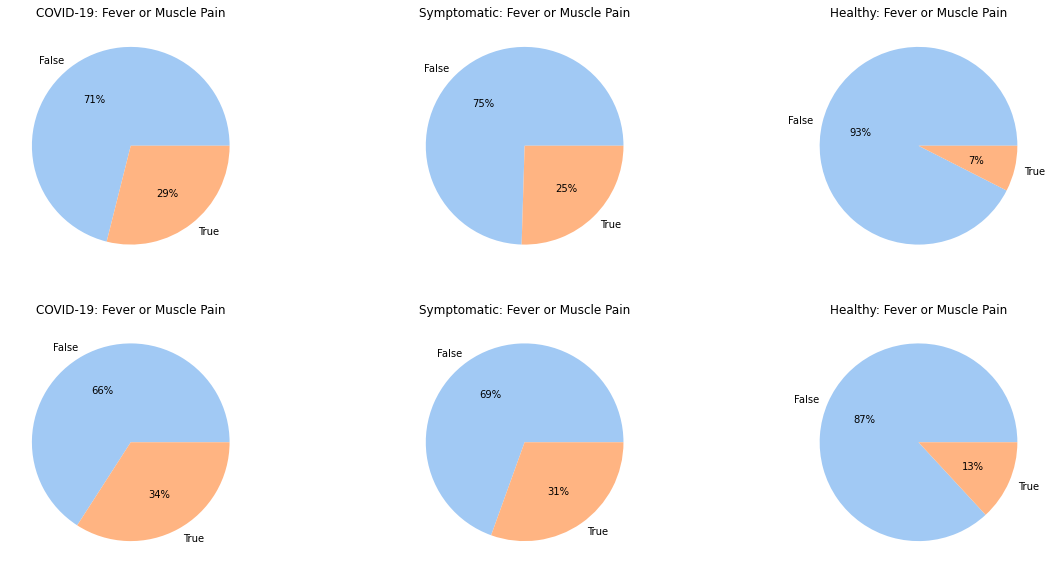

In [16]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
colors = sns.color_palette('pastel')

# fever_or_muscle_pain
axarr[0,0].pie(x=fever_mp['COVID-19']['label_count'], labels=fever_mp['COVID-19']['labels'], autopct = '%0.0f%%', colors=colors)
axarr[0,0].title.set_text('COVID-19: Fever or Muscle Pain')
axarr[0,1].pie(x=fever_mp['symptomatic']['label_count'], labels=fever_mp['symptomatic']['labels'], autopct = '%0.0f%%', colors=colors)
axarr[0,1].title.set_text('Symptomatic: Fever or Muscle Pain')
axarr[0,2].pie(x=fever_mp['healthy']['label_count'], labels=fever_mp['healthy']['labels'], autopct = '%0.0f%%', colors=colors)
axarr[0,2].title.set_text('Healthy: Fever or Muscle Pain')

# respiratory_condition
axarr[1,0].pie(x=respitory_cond['COVID-19']['label_count'], labels=respitory_cond['COVID-19']['labels'], autopct = '%0.0f%%', colors=colors)
axarr[1,0].title.set_text('COVID-19: Fever or Muscle Pain')
axarr[1,1].pie(x=respitory_cond['symptomatic']['label_count'], labels=respitory_cond['symptomatic']['labels'], autopct = '%0.0f%%', colors=colors)
axarr[1,1].title.set_text('Symptomatic: Fever or Muscle Pain')
axarr[1,2].pie(x=respitory_cond['healthy']['label_count'], labels=respitory_cond['healthy']['labels'], autopct = '%0.0f%%', colors=colors)
axarr[1,2].title.set_text('Healthy: Fever or Muscle Pain')

plt.show()

A patient with a fever or muscle pain and a respiratory condition is a good indicator to distinguish between Healthy and COVID-19 and Symptomatic coughs.

We recommend the mobile application include the following 'Yes' or 'No' questions to improve the machine learning model:


1.   Do you currently have a fever (> 100.4° F) or muscle pain?
2.   Do you currently suffer from a respiratory condition (e.g., Asthma, Chronic Obstructive Pulmonary Disease (COPD), Chronic Bronchitis, Emphysema, Lung Cancer, Cystic Fibrosis/Bronchiectasis, etc.)?

In [17]:
# restrict columns
columns = ['uuid', 'datetime', 'cough_detected', 'SNR', 'longitude', 'age', 'gender', 'fever_muscle_pain', 'respiratory_condition', 'status', 'file_path', 'wav_file_path', 'sr', 'length']
# remove NA columns that are in the following subset
na_columns = ['uuid', 'cough_detected', 'SNR', 'fever_muscle_pain', 'respiratory_condition', 'status']

eda_data = data[columns].copy()
eda_data.dropna(inplace=True, subset=na_columns)

### Evaluation #2: 'cough_detected' and 'SNR'

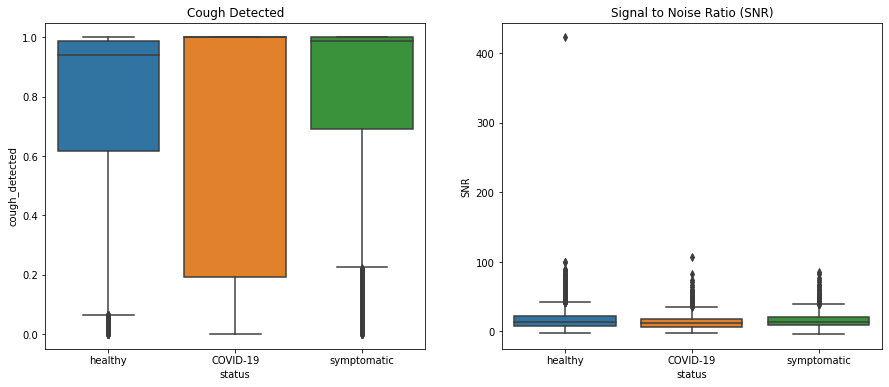

In [18]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sns.boxplot(x='status', y='cough_detected', data=eda_data, ax=axarr[0]).set_title('Cough Detected')
sns.boxplot(x='status', y='SNR', data=eda_data, ax=axarr[1]).set_title('Signal to Noise Ratio (SNR)')

plt.show()

The box plot for Cough Detected, shows that the cough detected above 0.90 are ideal for healthy, symptomatic, and COVID-19 and the rest are outliers and it is likely that these would be poor audio files to use in classification

In [19]:
eda_data = eda_data.loc[(data.cough_detected>=0.8)]

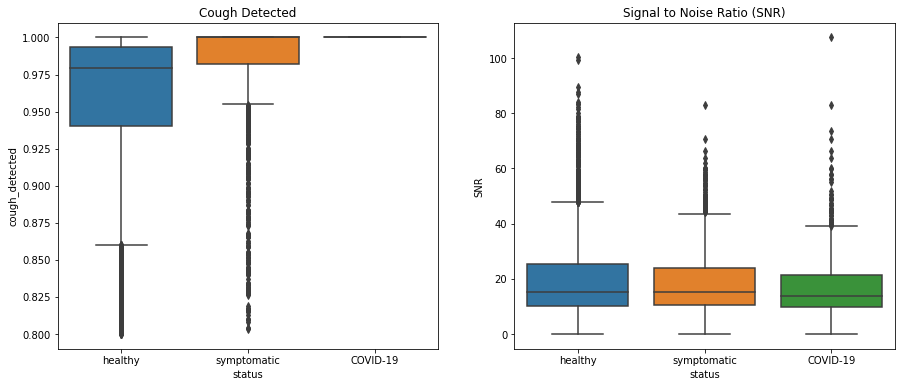

In [20]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
sns.boxplot(x='status', y='cough_detected', data=eda_data, ax=axarr[0]).set_title('Cough Detected')
sns.boxplot(x='status', y='SNR', data=eda_data, ax=axarr[1]).set_title('Signal to Noise Ratio (SNR)')

plt.show()

### Evaluation #3: 'Sampling Rate'

22050    10819
Name: sr, dtype: int64


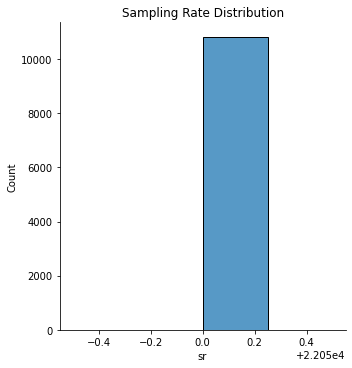

In [21]:
print(eda_data.sr.value_counts())

sns.displot(data=eda_data.sr, bins=4)
plt.title('Sampling Rate Distribution')
plt.show()

The majority of the sample rate (SR) values are 22,050

### Evaluation #4: 'Signal Length'

Full Dataset
	Median: 9.78
	MeanL 8.16
Sample Dataset
	Median: 9.72
	MeanL 8.27


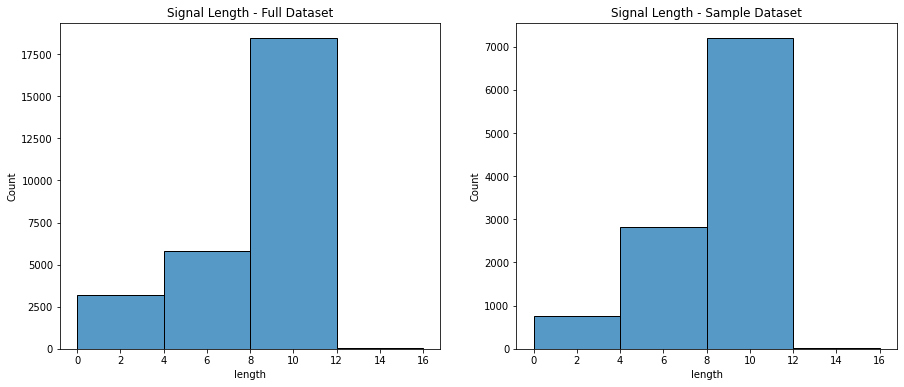

In [22]:
cough_detected_ratio = 0.8
na_columns = ['uuid', 'cough_detected', 'SNR', 'fever_muscle_pain', 'respiratory_condition', 'status']

sample_data = data[(data.cough_detected > cough_detected_ratio)].copy()
sample_data.dropna(inplace=True, subset=na_columns)
print('Full Dataset\n\tMedian: {}\n\tMeanL {}'.format(round(data.length.median(), 2), round(data.length.mean(), 2)))
print('Sample Dataset\n\tMedian: {}\n\tMeanL {}'.format(round(sample_data.length.median(), 2), round(sample_data.length.mean(), 2)))

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
#axarr[0].title = 'A'
sns.histplot(data=data.length, bins=4, binrange=(0,16), ax=axarr[0]).set_title('Signal Length - Full Dataset')
sns.histplot(data=sample_data.length, bins=4, binrange=(0,16), ax=axarr[1]).set_title('Signal Length - Sample Dataset')
plt.show()

The majority of signal lengths are above 9

### Evaluation #5: Agreement Amongst Doctors

Dry versus not dry cough. COVID-19 is known to have a dry cough

In [23]:
eda_data = data.loc[(data.cough_detected>=0.8) & (data.cough_type_1.notnull()) & (data.cough_type_2.notnull()) & (data.cough_type_3.notnull()) & (data.cough_type_4.notnull())].copy()
print('{} signals have been evaluated by all four expert doctors'.format(len(eda_data)))

127 signals have been evaluated by all four expert doctors


In [24]:
cough_type_per_doctor = {}
for i in range(4):
  col = 'cough_type_{}'.format(i+1)
  labels = eda_data[col].value_counts().keys().tolist()
  label_count = eda_data[col].value_counts().tolist()
  print(labels, label_count)
  cough_type_per_doctor.update({i: {'labels': labels, 'label_count': label_count}})

['dry', 'unknown', 'wet'] [78, 41, 8]
['dry', 'wet', 'unknown'] [94, 20, 13]
['dry', 'wet', 'unknown'] [60, 45, 22]
['dry', 'wet', 'unknown'] [106, 18, 3]


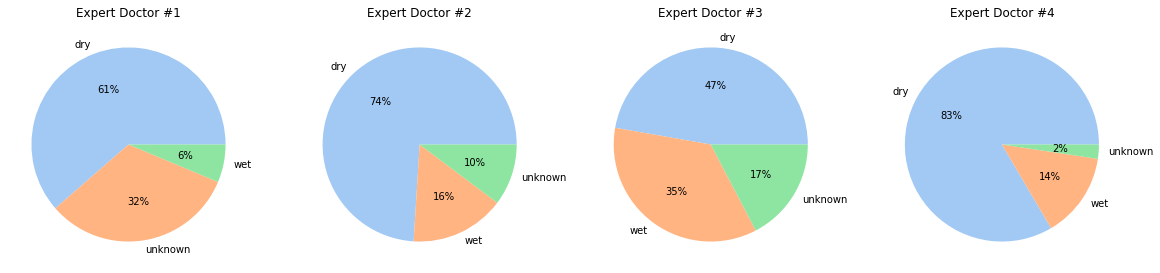

In [25]:
fig, axarr = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
colors = sns.color_palette('pastel')

# cough_type
axarr[0].pie(x=cough_type_per_doctor[0]['label_count'], labels=cough_type_per_doctor[0]['labels'], autopct = '%0.0f%%', colors=colors)
axarr[0].title.set_text('Expert Doctor #1')
axarr[1].pie(x=cough_type_per_doctor[1]['label_count'], labels=cough_type_per_doctor[1]['labels'], autopct = '%0.0f%%', colors=colors)
axarr[1].title.set_text('Expert Doctor #2')
axarr[2].pie(x=cough_type_per_doctor[2]['label_count'], labels=cough_type_per_doctor[2]['labels'], autopct = '%0.0f%%', colors=colors)
axarr[2].title.set_text('Expert Doctor #3')
axarr[3].pie(x=cough_type_per_doctor[3]['label_count'], labels=cough_type_per_doctor[3]['labels'], autopct = '%0.0f%%', colors=colors)
axarr[3].title.set_text('Expert Doctor #4')

plt.show()

Aggrement amongst expert doctors on sympthoms and diagnosis

In [26]:
def get_expert_doctor_data():
  expert_doctor_variable_cols = ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']

  table_cols = ['doctor', 'quality', 'cough', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']
  table = pd.DataFrame(columns=table_cols)
  for i in range(4):

    row = {i+1: None}

    # columns to select  
    cols = ['{}_{}'.format(expert_doctor_variable_cols[j], i+1) for j in range(len(expert_doctor_variable_cols))]
    # common column name across doctors
    col_friendly = {}
    for j in cols:
      col_friendly.update({j: j.split('_')[0]})
    # select doctor opinions
    col = 'cough_type_{}'.format(i+1)
    rows = eda_data.loc[eda_data[col].notnull()][cols]
    # translate to matrix
    np.full((len(rows)), i+1)
    rows.insert(0, 'doctor', np.full((len(rows)), i+1))
    # rename to friendly column names
    rows.rename(columns=col_friendly, inplace=True)
    # label_encode eeach column
    label_encoder = LabelEncoder()
    for column in rows:
      if column == 'doctor':
        # do nothing
        pass
      else:
        rows[column] = label_encoder.fit_transform(rows[column])
    # append to final table
  table = table.append(rows, ignore_index=True)
  return table
table = get_expert_doctor_data()

In [27]:
expert_doctor_variable_cols = ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']
descriptions = {
    'quality': 'Good; Ok; Poor; No cough present',
    'cough_type': 'Wet (productive); Dry; Can’t tell',
    'dyspnea': 'Audible dyspnea',
    'wheezing': 'Audible wheezing',
    'stridor': 'Audible stridor',
    'choking': 'Audible choking',
    'congestion': ' Audible nasal congestion',
    'nothing': 'Nothing specific',
    'diagnosis': 'Impression: I think this patient has: An upper respiratory tract infection; A lower respiratory tract infection; Obstructive lung disease (Asthma, COPD, …); COVID-19; Nothing (healthy cough)',
    'severity': 'mpression: the cough is probably…: Pseudocough/Healthy cough (from a healthy person); Mild (from a sick person); Severe (from a sick person); Can’t tell'
}

def get_kFleiss(table):
  kFleiss_list = {}
  for col in expert_doctor_variable_cols:
    table = pd.DataFrame()
    label_encoder = LabelEncoder()
    table['doctor1'] = label_encoder.fit_transform(eda_data['{}_1'.format(col)])
    table['doctor2'] = label_encoder.fit_transform(eda_data['{}_2'.format(col)])
    table['doctor3'] = label_encoder.fit_transform(eda_data['{}_3'.format(col)])
    table['doctor4'] = label_encoder.fit_transform(eda_data['{}_4'.format(col)])

    # get overall kFleiss
    agg_raters = irr.aggregate_raters(table)
    fleiss = irr.fleiss_kappa(agg_raters[0], method='fleiss')
    kFleiss_list.update({col: {'description': descriptions[col],'all': fleiss, 'individual': None, 'agg_raters': agg_raters}})

    # get matrix of kFleiss for each doctor
    fleiss_matrix = np.zeros((4, 4))
    for i in range(4):
      for j in range(4):
        a = 'doctor' + str(i+1) # source doctor
        b = 'doctor' + str(j+1) # target doctor

        if a == b: # skip; no need to compare the same doctor
          pass
        else:
          agg_raters = irr.aggregate_raters(table[[a, b]])
          fleiss = irr.fleiss_kappa(agg_raters[0], method='fleiss')
          fleiss_matrix[i][j] = fleiss
    kFleiss_list[col]['individual'] = fleiss_matrix
  return kFleiss_list

kFleiss_list = get_kFleiss(table)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/inter_rater.py:264: RuntimeWarning: invalid value encountered in double_scalars
  kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)


In [28]:
def get_kFleiss_interpretation(kFleiss, display_value=False, round_to=2):
  if display_value:
    kFleiss_round = str(round(kFleiss, round_to))
    if kFleiss == 0:
      return ''
    elif kFleiss < 0:
      return 'Poor agreement ({})'.format(kFleiss_round)
    elif kFleiss >= 0 and kFleiss <= 0.2:
      return 'Slight agreement ({})'.format(kFleiss_round)
    elif kFleiss > 0.2 and kFleiss <= 0.4:
      return 'Fair agreement ({})'.format(kFleiss_round)
    elif kFleiss > 0.4 and kFleiss <= 0.6:
      return 'Moderate agreement ({})'.format(kFleiss_round)
    elif kFleiss > 0.6 and kFleiss <= 0.8:
      return 'Substantial agreement ({})'.format(kFleiss_round)
    else:
      return 'Almost perfect agreement ({})'.format(kFleiss_round)
  else:
    if kFleiss < 0:
      return 'Poor agreement'
    elif kFleiss >= 0 and kFleiss <= 0.2:
      return 'Slight agreement'
    elif kFleiss > 0.2 and kFleiss <= 0.4:
      return 'Fair agreement'
    elif kFleiss > 0.4 and kFleiss <= 0.6:
      return 'Moderate agreement'
    elif kFleiss > 0.6 and kFleiss <= 0.8:
      return 'Substantial agreement'
    else:
      return 'Almost perfect agreement'

Display agreement amongst all doctors

In [29]:
kFleiss_all = pd.DataFrame(columns=['Item', 'kFleiss', 'Agreement'])
for variable, d in kFleiss_list.items():
  row = pd.DataFrame([[variable, round(d['all'], 2), get_kFleiss_interpretation(d['all'])]], columns=['Item',  'kFleiss', 'Agreement'])
  kFleiss_all = kFleiss_all.append(row, ignore_index=True)

kFleiss_all

Item  kFleiss           Agreement
0     quality    -0.09      Poor agreement
1  cough_type     0.25      Fair agreement
2     dyspnea    -0.02      Poor agreement
3    wheezing     0.06    Slight agreement
4     stridor    -0.01      Poor agreement
5     choking    -0.01      Poor agreement
6  congestion     0.41  Moderate agreement
7     nothing     0.13    Slight agreement
8   diagnosis    -0.03      Poor agreement
9    severity     0.14    Slight agreement

Display agreement between each doctor for cough type

In [30]:
kFleiss_cough = pd.DataFrame(kFleiss_list['cough_type']['individual'], columns=['Doctor #1', 'Doctor #2', 'Doctor #3', 'Doctor #4'])
kFleiss_cough.rename(index={0: 'Doctor #1', 1: 'Doctor #2', 2: 'Doctor #3', 3: 'Doctor #4'}, inplace=True)
kFkleiss_cough_agreement = kFleiss_cough.applymap(get_kFleiss_interpretation, display_value=True)

kFkleiss_cough_agreement

Doctor #1  ...                Doctor #4
Doctor #1                           ...  Slight agreement (0.17)
Doctor #2    Fair agreement (0.25)  ...    Fair agreement (0.24)
Doctor #3    Fair agreement (0.23)  ...  Slight agreement (0.18)
Doctor #4  Slight agreement (0.17)  ...                         

[4 rows x 4 columns]

Display agreement between each doctor for diagnosis

In [31]:
kFleiss_cough = pd.DataFrame(kFleiss_list['diagnosis']['individual'], columns=['Doctor #1', 'Doctor #2', 'Doctor #3', 'Doctor #4'])
kFleiss_cough.rename(index={0: 'Doctor #1', 1: 'Doctor #2', 2: 'Doctor #3', 3: 'Doctor #4'}, inplace=True)
kFkleiss_cough_agreement = kFleiss_cough.applymap(get_kFleiss_interpretation, display_value=True)

kFkleiss_cough_agreement

Doctor #1  ...                Doctor #4
Doctor #1                           ...  Slight agreement (0.09)
Doctor #2  Slight agreement (0.02)  ...   Poor agreement (-0.03)
Doctor #3   Poor agreement (-0.24)  ...   Poor agreement (-0.24)
Doctor #4  Slight agreement (0.09)  ...                         

[4 rows x 4 columns]

There is better agreement amongst doctors on the cough type versus diagnosis. 

The dataset may improve by imputing the values for each variable by changing the value to the majority value (e.g., if 3 doctors labeled the audio as a dry cough and 1 doctor labeled the audio as a wet cought the wet cought will be imputed to dry for all doctors)

In [32]:
imputed_values = kFleiss_list['cough_type']['agg_raters'][0].argmax(axis=1)
print(imputed_values)
print('')
(unique, counts) = np.unique(ar=imputed_values, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[0 0 2 0 1 0 0 0 0 2 1 0 0 0 0 1 0 0 2 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 2 0
 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 2 0 2 0 1 1 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 2 0 2 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]

[[  0 103]
 [  1  11]
 [  2  13]]


The dataset is imbalanced with dry coughs between the doctors

All of Doctor 1

In [33]:
data['cough_type_1'].value_counts()

dry        425
unknown    305
wet         72
Name: cough_type_1, dtype: int64

All of Doctor 2

In [34]:
data['cough_type_2'].value_counts()

dry        600
wet        132
unknown     69
Name: cough_type_2, dtype: int64

All of Doctor 3

In [35]:
data['cough_type_3'].value_counts()

dry        358
wet        291
unknown    146
Name: cough_type_3, dtype: int64

All of Doctor 4

In [36]:
data['cough_type_4'].value_counts()

dry        653
wet        120
unknown     28
Name: cough_type_4, dtype: int64

The data is still imbalaned for dry coughs with doctor 1 and 3 less imbalanced. The machine learning model should test classifying each doctor independently and together

## Data Pre-processing

### Filter audio files using metadata provided by the dataset

In [37]:
label_encoders = {}

def restrict_data_and_drop_na(_data):
  """
  Retricts the columns to: 'uuid', 'datetime', 'cough_detected', 'SNR', 'longitude', 'age', 'gender', 'fever_muscle_pain', 'respiratory_condition', 'status', 'file_path', 'wav_file_path', 'sr', 'length'
  Restriction will be extended to include expert doctor variables: ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']
  Remove rows where NA on columns: 'uuid', 'cough_detected', 'SNR', 'fever_muscle_pain', 'respiratory_condition', 'status', 'file_path', 'wav_file_path', 'sr', 'length' or expert doctor variables:
  ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']

  :return: _data; pandas dataframe
  """
  # main columns
  columns = ['uuid', 'datetime', 'cough_detected', 'SNR', 'longitude', 'age', 'gender', 'fever_muscle_pain', 'respiratory_condition', 'status', 'file_path', 'wav_file_path', 'sr', 'length']
  # expert doctor columns
  doctor_variables = []
  for i in range(4):
    cols = [col + '_' + str(i+1) for col in ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']]
    doctor_variables = doctor_variables + cols
  # add expert doctor columns to columns
  columns = columns + doctor_variables
  # Null columns
  na_columns_main = ['uuid', 'cough_detected', 'SNR', 'file_path', 'wav_file_path', 'sr', 'length']
  na_columns_or = [ 'fever_muscle_pain', 'respiratory_condition', 'status'] + doctor_variables

  # copy df
  _data = data[columns].copy()
  # drop 'na_columns_main' if any value is Null 
  _data.dropna(inplace=True, subset=na_columns_main)
  # drop 'na_columns_or' only if all of the values are Null
  _data.dropna(inplace=True, how='all', subset=na_columns_or)

  return _data

def remove_low_cough_detected_levels(_data):
  """
  Removes rows where the cough detected is not ideal
  Cough detected is a calcuation of how well a known cough is detected in the audio clip and is a signal of a quality recording
  """
  _data = _data.loc[(_data.cough_detected>=0.8)]
  return _data

def label_encode_doctor_variables(column, table):
  """
  Label encodes the expert doctor columns
  """
  label_encoder = LabelEncoder()

  for i in range(4):
    col = column + '_' + str(i+1)
    df = table[['uuid', col]].dropna().copy()
    label_encoders.update({col: label_encoder})
    df[col] = label_encoder.fit_transform(df[col])

    vdic = pd.Series(df[col].values, index=df['uuid']).to_dict()
    table.loc[table['uuid'].isin(vdic.keys()), col] = table.loc[table['uuid'].isin(vdic.keys()), 'uuid'].map(vdic)
  return table

def label_data(_data):
  """
  Encode target labels with value between 0 and n_classes-1.
  """
  label_encoder = LabelEncoder()
  _data['status'] = label_encoder.fit_transform(_data.status)
  label_encoders.update({'status': label_encoder})
  _data['fever_muscle_pain'] = label_encoder.fit_transform(_data.fever_muscle_pain)
  label_encoders.update({'fever_muscle_pain': label_encoder})
  _data['respiratory_condition'] = label_encoder.fit_transform(_data.respiratory_condition)
  label_encoders.update({'respiratory_condition': label_encoder})

  # doctor columns
  for col in ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']:
    _data = label_encode_doctor_variables(col, _data)

  return _data

def get_majority_doctor_variables(column, table):
  # get columns for each doctor
  cols = [column + '_' + str(i+1) for i in range(4)]
  # limit data to only the columns
  df = table[cols].dropna().reset_index()
  # get the aggregate
  agg_raters = irr.aggregate_raters(df[cols])
  col_majority_agg = agg_raters[0].argmax(axis=1)
  # store the majority value in a new column: 'col_majority'
  col_majority = column + '_majority'
  df[col_majority] = np.nan
  df[col_majority] = df[col_majority].astype(object)
  for df_idx in df.index:
    df.iloc[df_idx, df.columns.get_loc(col_majority)] = int(col_majority_agg[df_idx])
  df.set_index('index', inplace=True)
  # merge to original dataframe
  table = table.merge(df[col_majority], left_index=True, right_index=True, how='left')

  return table

def impute_data(_data):
  """
  Impute the status column so only COVID-19 or Not COVID-19 are possible choices
  """
  _data['status'] = _data['status'].apply(lambda row: 0 if row == 0 else 1)
  # add majority class for doctor variables
  for col in ['quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing', 'diagnosis', 'severity']:
    _data = get_majority_doctor_variables(col, _data)
  
  return _data

def sanitize_data(_data):
  # load the data from the pickle file
  data = pickle.load(open(data_path,'rb'))

  # Remove columns with high null or NA rows and where status is null
  sanitized_data = restrict_data_and_drop_na(data)
  print('...Limited the columns and removed NA values')
  # Remove rows that have low cough detected ratio; inidcator of how well a known cough is detected in the audio clip and is a signal of a quality recording
  sanitized_data = remove_low_cough_detected_levels(sanitized_data)
  print('...Removed rows that have low cough detected ratio; inidcator of how well a known cough is detected in the audio clip and is a signal of a quality recording')
  # Label the classes
  sanitized_data = label_data(sanitized_data)
  print('...Encoded target classes and features with value between 0 and n_classes-1 for use in machine learning models')
  # Impute the status column so only COVID-19 or Not COVID-19 are possible choices and the majority is calculated for cough type and diagnosis of expert doctors
  sanitized_data = impute_data(sanitized_data)
  print('...Imputed the status column so only COVID-19 or Not COVID-19 are possible choices for status and the majority is calculated for cough type and diagnosis of expert doctors')

  return sanitized_data

In [38]:
clean_data = sanitize_data(data)

clean_data.head()

...Limited the columns and removed NA values
...Removed rows that have low cough detected ratio; inidcator of how well a known cough is detected in the audio clip and is a signal of a quality recording
...Encoded target classes and features with value between 0 and n_classes-1 for use in machine learning models
...Imputed the status column so only COVID-19 or Not COVID-19 are possible choices for status and the majority is calculated for cough type and diagnosis of expert doctors


uuid  ... severity_majority
1   00039425-7f3a-42aa-ac13-834aaa2b6b92  ...               NaN
3   0009eb28-d8be-4dc1-92bb-907e53bc5c7a  ...               NaN
5   001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f  ...               NaN
10  0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952  ...               NaN
11  00291cce-36a0-4a29-9e2d-c1d96ca17242  ...               NaN

[5 rows x 64 columns]

## Feature Extraction

Feature extraction will consist of:



*   **Mel spectrogram (MFCC)** - a spectrogram where the frequencies are converted to the mel scale; In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the mel scale.







Generate Training data and split into train and validation

In [39]:
median_length = int(clean_data.length.median() * 1000) # convert to milliseconds

def get_spectrogram(_data, data_augmentation = True, n_mfcc = 128):
  result = None
  file_path = _data['wav_file_path']
  uuid = _data['uuid']
  f = AudioProcessing(file_path=file_path, resize_to=median_length)
  specs = f.generate_data_augmentation_spectrograms(data_augmentation=data_augmentation)

  result = {uuid: None}
  for i in range(len(specs)):
    # spectrogram_list
    spec = specs[i][0]
    spec_augmented = specs[i][1]
    mfccs = librosa.feature.mfcc(S=spec, n_mfcc=n_mfcc)
    mfccs_augmented = librosa.feature.mfcc(S=spec_augmented, n_mfcc=n_mfcc)

    if result[uuid] == None:
      result[uuid] = {i: {'spectrogram': spec, 'spectrogram_augmented': spec_augmented, 'mfccs': mfccs, 'mfccs_augmented': mfccs_augmented}}
    else:
      old = result[uuid]
      new = {i: {'spectrogram': spec, 'spectrogram_augmented': spec_augmented, 'mfccs': mfccs, 'mfccs_augmented': mfccs_augmented}}
      result[uuid] = {**old, **new}

  return result

In [40]:
re_run = False

In [41]:
spectrograms_path = audiofile_converted_path + 'spectrograms_all_' #.pkl'
length = len(clean_data)

if re_run:
  n_count = 1
  batch = 1
  spectrograms = {}

  with tqdm(total=length, position=0, leave=True) as pbar:
    for idx in range(length):
      result = get_spectrogram(_data=clean_data.iloc[idx], data_augmentation=True)
      spectrograms.update(result)

      # save spectrograms - checkpoint
      if n_count % 500 == 0:
        save_path = spectrograms_path + str(batch) + '.pkl'
        pickle.dump(spectrograms, open(save_path, 'wb'))
        spectrograms = {}
        batch += 1

      n_count += 1
      pbar.update()
  save_path = spectrograms_path + str(batch) + '.pkl'
  pickle.dump(spectrograms, open(save_path, 'wb'))

In [42]:
generated_data_path = audiofile_converted_path + 'spectrograms_batch_mapping.pkl'

if not os.path.isfile(path=generated_data_path):
  # batch number
  batch = 1
  # column to store the spectrogram batch
  if 'spectrogram_batch' not in clean_data.columns:
    clean_data['spectrogram_batch'] = np.nan
    clean_data['spectrogram_batch'] = clean_data['spectrogram_batch'].astype(object)

  # loop through every row
  start, end = 0, 0
  for idx in range(length):
    if (idx+1) % 500 == 0:
      # set the end index, +1 to include the last index in the return
      end = idx+1
      # store the batch in the dataframe
      clean_data.iloc[start:end, clean_data.columns.get_loc('spectrogram_batch')] = int(batch)
      # increase the start index and batch
      start = end
      batch += 1
  # store the last batch in the dataframe
  clean_data.iloc[start:, clean_data.columns.get_loc('spectrogram_batch')] = int(batch)
  pickle.dump(clean_data, open(generated_data_path, 'wb'))
  print('Created pre-generated data with batch mapping')
else:
  with open(generated_data_path, 'rb') as f:
    clean_data = pickle.load(f)
    print('Loaded pre-generated data with batch mapping')

Loaded pre-generated data with batch mapping


In [43]:
# expert doctors
sample_doctors_majority = clean_data.loc[~clean_data['cough_type_majority'].isnull()]
sample_doctors_doctor1 = clean_data.loc[~clean_data['cough_type_1'].isnull()]
sample_doctors_doctor2 = clean_data.loc[~clean_data['cough_type_2'].isnull()]
sample_doctors_doctor3 = clean_data.loc[~clean_data['cough_type_3'].isnull()]
sample_doctors_doctor4 = clean_data.loc[~clean_data['cough_type_4'].isnull()]


# covid or not covid
individual_covid_status = clean_data.loc[~clean_data['status'].isnull()]

n_per_class = individual_covid_status.status.value_counts()
n = n_per_class[n_per_class.idxmin()]

_sample = pd.DataFrame()
for index, value in n_per_class.items():
  if len(individual_covid_status.loc[individual_covid_status.status == index]) < n:
    class_sample = individual_covid_status.loc[individual_covid_status.status == index]
  else:
    class_sample = individual_covid_status.loc[individual_covid_status.status == index].sample(n=n)
  sample = [_sample, class_sample]
  _sample = pd.concat(sample)

individual_covid_status = _sample

In [44]:
def load_spectrogram_batch(batch_id):
  spectrograms = {}

  # path where the batch is stored
  save_path = spectrograms_path + str(batch_id) + '.pkl'
  # load batch and append to the dictioanary spectrograms
  with open(save_path, 'rb') as f:
    spectrograms_load = pickle.load(f)
  spectrograms =  {**spectrograms, **spectrograms_load}
  # clear memory or memory will run out
  del spectrograms_load
  gc.collect()
  print('...Loaded: {}'.format(save_path))

  return spectrograms

def merge_spectrograms(_data, predict_class, subset_type):
  # path to save the generated data
  save_path = audiofile_converted_path + subset_type + '.pkl'

  print('Starting: {}'.format(subset_type))
  
  # get unique batch within the sample
  batch_ids = _data['spectrogram_batch'].unique()
  # create dataframe to export
  sample_generated_data_df = pd.DataFrame(columns=['uuid', 'spectrogram', 'spectrogram_augmented', 'mfccs', 'mfccs_augmented', 'target_class'])

  # loop through each batch
  for batch_id in batch_ids:
    # load pre-generated spectrograms per batch
    spectrograms = load_spectrogram_batch(batch_id)
    # loop through each uuid
    for idx, row in _data.loc[_data['uuid'].isin(spectrograms.keys())].iterrows():
      uuid = row['uuid']
      target_class = int(row[predict_class])
      # loop through each spectrogram per uuid
      for mel_spec in spectrograms[uuid].keys():
        spectrogram = spectrograms[uuid][mel_spec]['spectrogram']
        spectrogram_augmented = spectrograms[uuid][mel_spec]['spectrogram_augmented']
        mfccs = spectrograms[uuid][mel_spec]['mfccs']
        mfccs_augmented = spectrograms[uuid][mel_spec]['mfccs_augmented']
        new_row = {'uuid': uuid, 'spectrogram': spectrogram, 'spectrogram_augmented': spectrogram_augmented, 'mfccs': mfccs, 'mfccs_augmented': mfccs_augmented, 'target_class': target_class}
        sample_generated_data_df = sample_generated_data_df.append(new_row, ignore_index=True)
  sample_generated_data_df['target_class'] = sample_generated_data_df['target_class'].astype(int)
  pickle.dump(sample_generated_data_df, open(save_path, 'wb'))

  # clear memory
  del spectrograms
  del sample_generated_data_df
  gc.collect()

  print('Completed: {}'.format(subset_type))
  print('\tSaved to: {}'.format(save_path))

In [45]:
re_run = False

In [46]:
if re_run:
  merge_spectrograms(_data=sample_doctors_majority, predict_class='cough_type_majority', subset_type='doctors_majority_cough_type_majority')
  merge_spectrograms(_data=sample_doctors_doctor1, predict_class='cough_type_1', subset_type='doctor1_cough_type_1')
  merge_spectrograms(_data=sample_doctors_doctor2, predict_class='cough_type_2', subset_type='doctor2_cough_type_2')
  merge_spectrograms(_data=sample_doctors_doctor3, predict_class='cough_type_3', subset_type='doctor3cough_type_3')
  merge_spectrograms(_data=sample_doctors_doctor4, predict_class='cough_type_4', subset_type='doctor4cough_type_4')
  merge_spectrograms(_data=individual_covid_status, predict_class='status', subset_type='individual_status')

## Model Creation

### Data Generator

In [47]:
class CustomDataset(utils.Sequence):
  def __init__(self, data_x, labels, batch_size=128, shuffle=False, n_classes=1):
    self.batch_size = batch_size
    self.features = data_x
    self.dim = (self.features.shape[1], self.features.shape[2])
    self.n_channels = self.features.shape[3]
    self.labels = labels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()
  
  def __len__(self):
      return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    # generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, indexes):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]

    return X, utils.to_categorical(y, num_classes=self.n_classes)

In [48]:
class CustomPipeline(utils.Sequence):
  def __init__(self, data_x, data_y, batch_size=48, shuffle=False, n_classes=1):
    self.features = data_x
    self.labels = data_y
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes = n_classes
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))
  
  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    # generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]

    return X, utils.to_categorical(y, num_classes=self.n_classes)

In [49]:
class SingleInputGenerator(utils.Sequence):
  """
  Wrapper of two generators for the combined input model
  """
  def __init__(self, X1, Y, batch_size, target_size=(128,128), n_classes=1, shuffle=False):
    self.genX1 = CustomDataset(X1, Y, batch_size=batch_size, shuffle=shuffle, n_classes=n_classes)
    self.n_classes = n_classes

  def __len__(self):
    return self.genX1.__len__()

  def get_shapes(self):
    return (*self.genX1.dim, self.genX1.n_channels)

  def get_n_classes(self):
    return self.n_classes

  def __getitem__(self, index):
    X1_batch, Y_batch = self.genX1.__getitem__(index)
    X_batch = [X1_batch]
    return X_batch, Y_batch

### Select Subset of Data for Training

In [50]:
subsets = {
#    'doctors_majority_cough_type_majority':  {'target_class': 'cough_type_majority', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctors_majority_cough_type_majority.pkl'},
    'doctor1_cough_type_1': {'target_class': 'cough_type_1', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor1_cough_type_1.pkl'},
#    'doctor2_cough_type_2': {'target_class': 'cough_type_2', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor2_cough_type_2.pkl'},
#    'doctor3_cough_type_3': {'target_class': 'cough_type_3', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor3cough_type_3.pkl'},
#    'doctor4_cough_type_4': {'target_class': 'cough_type_4', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor4cough_type_4.pkl'},
#    'individual_status': {'target_class': 'status', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/individual_status.pkl'}
}

#### Evaluate the current distribution of classes

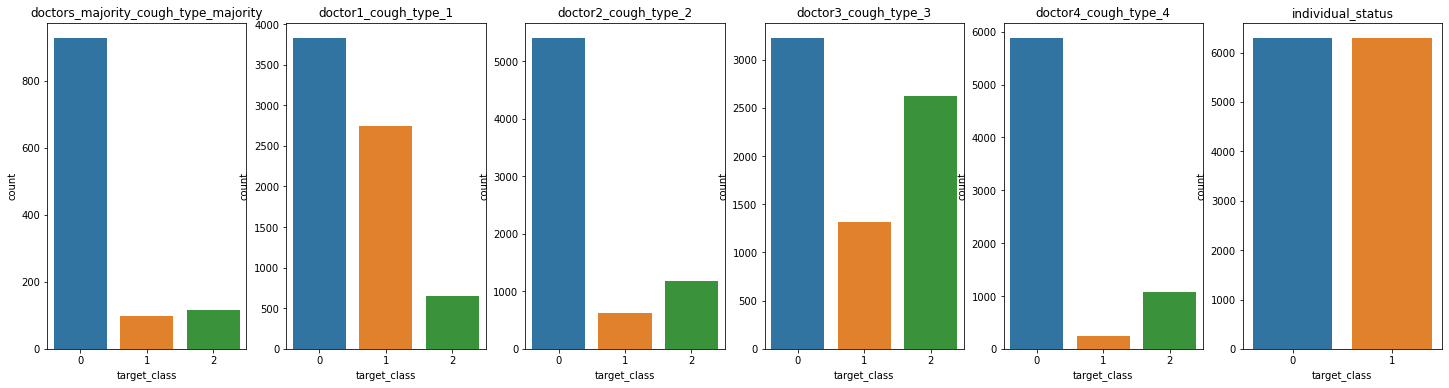

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=6, figsize=(25,6))

idx = 0
for subset_type in subsets.keys():
  file_path = subsets[subset_type]['file_path']
  target_class = subsets[subset_type]['target_class']
  # load subset_type
  with open(file_path, 'rb') as f:
    sample = pickle.load(f)
  sns.countplot(x='target_class', data=sample, ax=axarr[idx]).set_title(subset_type)
  idx+=1

  del sample
  gc.collect()
plt.show()

The data is imbalanced. Data will be modified to only have two classes. For expert doctors the classes will be Dry or Not Dry cough and for individual statuses the classes will be COVID-19 or Not COVID-19

#### Run datagenerator for each subset

In [51]:
def get_data_generator(subset_type, n_data_augmentation=1, two_class_only=False):
  print('Starting subset type: {}'.format(subset_type))
  file_path = subsets[subset_type]['file_path']
  target_class = subsets[subset_type]['target_class']
  # load subset_type
  with open(file_path, 'rb') as f:
    sample = pickle.load(f)
  print('...Loaded data')

  # split into train and validation
  s = sample[['uuid', 'target_class']].drop_duplicates()
  if two_class_only:
    s['target_class'] = s['target_class'].apply(lambda row: 0 if row == 0 else 1)

  X = s['uuid']
  y = s['target_class']
  n_classes = len(y.unique())
  X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
  print('...Split data: train = {}, validation = {}'.format(len(X_train), len(X_validation)))
  
  # training data
  s = sample[['uuid', 'mfccs_augmented', 'target_class']].loc[sample['uuid'].isin(X_train)].groupby('uuid').head(n_data_augmentation)[['mfccs_augmented', 'target_class']]
  if two_class_only:
    s['target_class'] = s['target_class'].apply(lambda row: 0 if row == 0 else 1)
  train_mfccs = np.array([s['mfccs_augmented'].iloc[i] for i in range(len(s))], dtype='object')
  train_mfccs = train_mfccs.reshape(train_mfccs.shape[0], train_mfccs.shape[1], train_mfccs.shape[2], 1)
  train_labels = np.array([s['target_class'].iloc[i] for i in range(len(s))])
  print('...Loaded training data using {} data augmentation types: train_mfccs shape = {}, train_lables shape = {}'.format(n_data_augmentation, train_mfccs.shape, train_labels.shape))
  # validation data
  s = sample[['uuid', 'mfccs_augmented', 'target_class']].loc[sample['uuid'].isin(X_validation)].groupby('uuid').head(1)[['mfccs_augmented', 'target_class']]
  if two_class_only:
    s['target_class'] = s['target_class'].apply(lambda row: 0 if row == 0 else 1)
  validation_mfccs = np.array([s['mfccs_augmented'].iloc[i] for i in range(len(s))], dtype='object')
  validation_mfccs = validation_mfccs.reshape(validation_mfccs.shape[0], validation_mfccs.shape[1], validation_mfccs.shape[2], 1)
  validation_labels = np.array([s['target_class'].iloc[i] for i in range(len(s))])
  print('...Loaded validation data: validation_mfccs shape = {}, validation_labels shape = {}'.format(validation_mfccs.shape, validation_labels.shape))

  
  # Get Training Features
  train_gen = SingleInputGenerator(X1=train_mfccs, Y=train_labels, batch_size=128, n_classes=n_classes, shuffle=True)
  validation_gen = SingleInputGenerator(X1=validation_mfccs, Y=validation_labels, batch_size=1, n_classes=n_classes)
  print('...Loaded train and validation data generator')

  del sample
  del s
  del train_mfccs
  del train_labels
  del validation_mfccs
  del validation_labels
  gc.collect()

  return train_gen, validation_gen

In [52]:
def get_data_generator_2d(subset_type, n_data_augmentation=1, two_class_only=False):
  print('Starting subset type: {}'.format(subset_type))
  file_path = subsets[subset_type]['file_path']
  target_class = subsets[subset_type]['target_class']
  # load subset_type
  with open(file_path, 'rb') as f:
    sample = pickle.load(f)
  print('...Loaded data')

  # split into train and validation
  s = sample[['uuid', 'target_class']].drop_duplicates()
  if two_class_only:
    s['target_class'] = s['target_class'].apply(lambda row: 0 if row == 0 else 1)

  X = s['uuid']
  y = s['target_class']
  n_classes = len(y.unique())
  X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
  print('...Split data: train = {}, validation = {}'.format(len(X_train), len(X_validation)))
  
  # training data
  s = sample[['uuid', 'mfccs_augmented', 'target_class']].loc[sample['uuid'].isin(X_train)].groupby('uuid').head(n_data_augmentation)[['mfccs_augmented', 'target_class']]
  if two_class_only:
    s['target_class'] = s['target_class'].apply(lambda row: 0 if row == 0 else 1)
  train_mfccs = np.array([s['mfccs_augmented'].iloc[i] for i in range(len(s))], dtype='object')
  n_samples, n_x, n_y = train_mfccs.shape
  train_mfccs = train_mfccs.reshape((n_samples, n_x*n_y))
  train_labels = np.array([s['target_class'].iloc[i] for i in range(len(s))])
  train_labels = utils.to_categorical(train_labels, num_classes=n_classes)
  print('...Loaded training data using {} data augmentation types: train_mfccs shape = {}, train_lables shape = {}'.format(n_data_augmentation, train_mfccs.shape, train_labels.shape))

  # validation data
  s = sample[['uuid', 'mfccs_augmented', 'target_class']].loc[sample['uuid'].isin(X_validation)].groupby('uuid').head(1)[['mfccs_augmented', 'target_class']]
  if two_class_only:
    s['target_class'] = s['target_class'].apply(lambda row: 0 if row == 0 else 1)
  validation_mfccs = np.array([s['mfccs_augmented'].iloc[i] for i in range(len(s))], dtype='object')
  n_samples, n_x, n_y = validation_mfccs.shape
  validation_mfccs = validation_mfccs.reshape((n_samples, n_x*n_y))
  validation_labels = np.array([s['target_class'].iloc[i] for i in range(len(s))])
  validation_labels = utils.to_categorical(validation_labels, num_classes=n_classes)
  print('...Loaded validation data: validation_mfccs shape = {}, validation_labels shape = {}'.format(validation_mfccs.shape, validation_labels.shape))

  del sample
  del s
  gc.collect()

  return (train_mfccs, train_labels), (validation_mfccs, validation_labels), (n_classes)

## Run Models

### Convolutional Neural Network (CNN)

Build the neural network

In [ ]:
def build_cnn_model(input_shape, n_classes=1):
  """
  Function to build ensembile model
  
  model 1: Mel spectrogram (MFCC)
  """
  # model 1: Mel spectrogram (MFCC)
  model1_input = layers.Input(shape=input_shape)
  model1_layer1 = layers.Conv2D(filters=16, kernel_size=2, activation='relu')(model1_input)
  model1_layer2 = layers.MaxPooling2D(pool_size=2)(model1_layer1)
  model1_layer3 = layers.Dropout(rate=0.2)(model1_layer2)

  model1_layer4 = layers.Conv2D(filters=32, kernel_size=2, activation='relu')(model1_layer3)
  model1_layer5 = layers.MaxPooling2D(pool_size=2)(model1_layer4)
  model1_layer6 = layers.Dropout(rate=0.2)(model1_layer5)

  model1_layer7 = layers.Conv2D(filters=64, kernel_size=2, activation='relu')(model1_layer6)
  model1_layer8 = layers.MaxPooling2D(pool_size=2)(model1_layer7)
  model1_layer9 = layers.Dropout(rate=0.2)(model1_layer8)

  model1_layer10 = layers.Conv2D(filters=128, kernel_size=2, activation='relu')(model1_layer9)
  model1_layer11 = layers.MaxPooling2D(pool_size=2)(model1_layer10)
  model1_layer12 = layers.Dropout(rate=0.5)(model1_layer11)
  model1_layer13 = layers.GlobalAveragePooling2D()(model1_layer12)

  model1_layer14 = layers.Flatten()(model1_layer13)
  output = layers.Dense(units=n_classes, activation='softmax')(model1_layer14)
  model = models.Model(inputs=[model1_input], outputs=output)

  return model

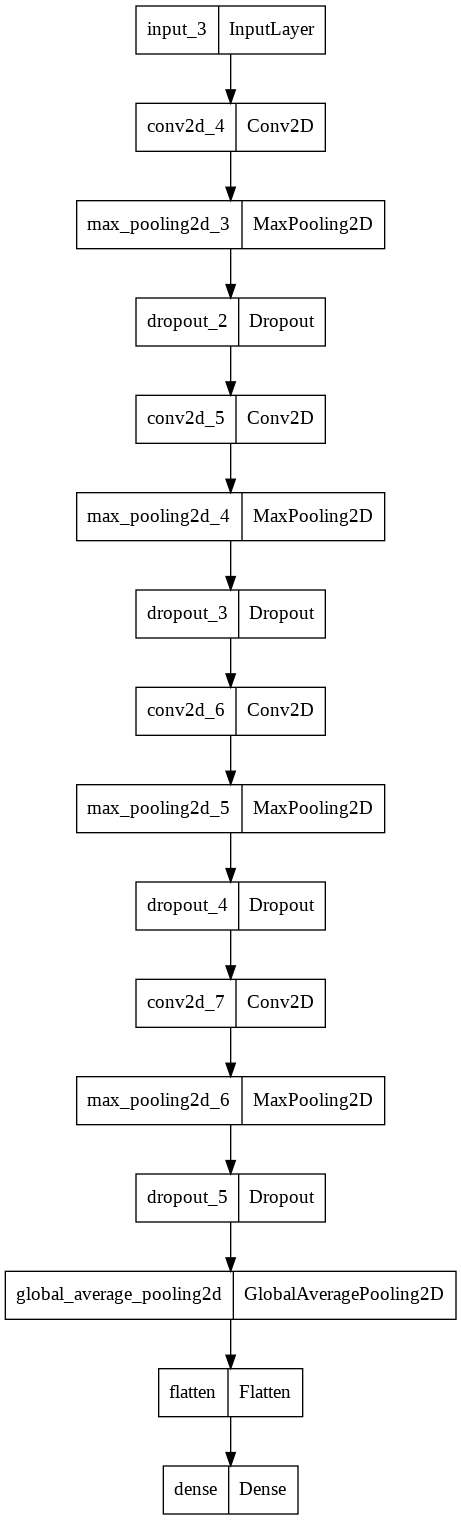

In [ ]:
# some fake input shape so we can display model
utils.plot_model(build_cnn_model((128, 888, 1), n_classes=2))

#### Train the models

In [ ]:
n_epochs = 1000

for subset_type in subsets.keys():
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9)
  n_classes = train_gen.get_n_classes()

  # load and compile model
  print('')
  print('-'*20 + '   Compile Model   ' + '-'*20)
  model = build_cnn_model(train_gen.get_shapes(), n_classes=n_classes)
  optimizer = optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer, loss='categorical_crossentropy', metrics=['AUC', 'accuracy'])
  print(model.summary())

  # run model
  print('')
  print('-'*20 + '   Train Model   ' + '-'*20)
  model_save_path = audiofile_converted_path + subset_type + '_cnn_model.h5'
  history_save_path = audiofile_converted_path + subset_type + '_cnn_history.pkl'

  save_best_callback = callbacks.ModelCheckpoint(filepath=model_save_path, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
  history = model.fit(x=train_gen, validation_data=validation_gen, epochs=n_epochs, callbacks=[save_best_callback])
  pickle.dump(history.history, open(history_save_path, 'wb'))

Starting subset type: individual_status
...Loaded data
...Split data: train = 1118, validation = 280
...Loaded training data using 9 data augmentation types: train_mfccs shape = (10062, 64, 836, 1), train_lables shape = (10062,)
...Loaded validation data: validation_mfccs shape = (280, 64, 836, 1), validation_labels shape = (280,)
...Loaded train and validation data generator

--------------------   Compile Model   --------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 836, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 63, 835, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 417, 16)      0         
 )                                                               
                 

#### Evaluate the models

In [ ]:
def evaluate_dnn_model(history, best_model, t_gen, v_gen, subset_type):
  history_df = pd.DataFrame(history)

  fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(20,15))
  p1 = sns.lineplot(data=history_df, y='val_accuracy', x=range(history_df.shape[0]), ax=axarr[0, 0]).set_title('Validation Accuracy')
  p2 = sns.lineplot(data=history_df, y='val_loss', x=range(history_df.shape[0]), ax=axarr[0, 1]).set_title('Validation Loss')
  p3 = sns.lineplot(data=history_df, y='val_auc', x=range(history_df.shape[0]), ax=axarr[0, 2]).set_title('Validation ROC AUC')
  p4 = sns.lineplot(data=history_df, y='accuracy', x=range(history_df.shape[0]), ax=axarr[1, 0]).set_title('Training Accuracy')
  p5 = sns.lineplot(data=history_df, y='loss', x=range(history_df.shape[0]), ax=axarr[1, 1]).set_title('Training Loss')
  p6 = sns.lineplot(data=history_df, y='auc', x=range(history_df.shape[0]), ax=axarr[1, 2]).set_title('Training ROC AUC')
  axarr[0, 1].set_xlabel('Epochs')
  axarr[0, 1].set_xlabel('Epochs')
  axarr[0, 2].set_xlabel('Epochs')
  axarr[1, 1].set_xlabel('Epochs')
  axarr[1, 1].set_xlabel('Epochs')
  axarr[1, 2].set_xlabel('Epochs')
  fig.suptitle('Performance: ' + subset_type, fontsize=16)

  plt.show()

  del history_df
  gc.collect()

  # get predictions of train and validation
  Y_train_pred = best_model.predict(t_gen).argmax(axis=-1)
  Y_validation_pred = best_model.predict(v_gen).argmax(axis=-1)
  # get labels from each batch
  y_lables_validation = []
  for x, y in v_gen:
    y_lables_validation = [*y_lables_validation, *y.argmax(axis=-1)]
  y_lables_training = []
  for x, y in t_gen:
    y_lables_training = [*y_lables_training, *y.argmax(axis=-1)]

  # display results
  print('-'*30 + ' VALIDATION ' + '-'*30)
  print(classification_report(y_lables_validation, Y_validation_pred, zero_division=1))
  print('-'*30 + ' TRAINING ' + '-'*30)
  print(classification_report(y_lables_training, Y_train_pred, zero_division=1))

  del Y_train_pred
  del Y_validation_pred
  del y_lables_validation
  del y_lables_training
  gc.collect()

Evaluation of:


*   doctors_majority_cough_type_majority
*   doctor1_cough_type_1
*   doctor2_cough_type_2
*   doctor3_cough_type_3

Rest are in the next cell because it took too much memory





Starting subset type: doctors_majority_cough_type_majority
...Loaded data
...Split data: train = 101, validation = 26
...Loaded training data using 9 data augmentation types: train_mfccs shape = (909, 64, 836, 1), train_lables shape = (909,)
...Loaded validation data: validation_mfccs shape = (26, 64, 836, 1), validation_labels shape = (26,)
...Loaded train and validation data generator


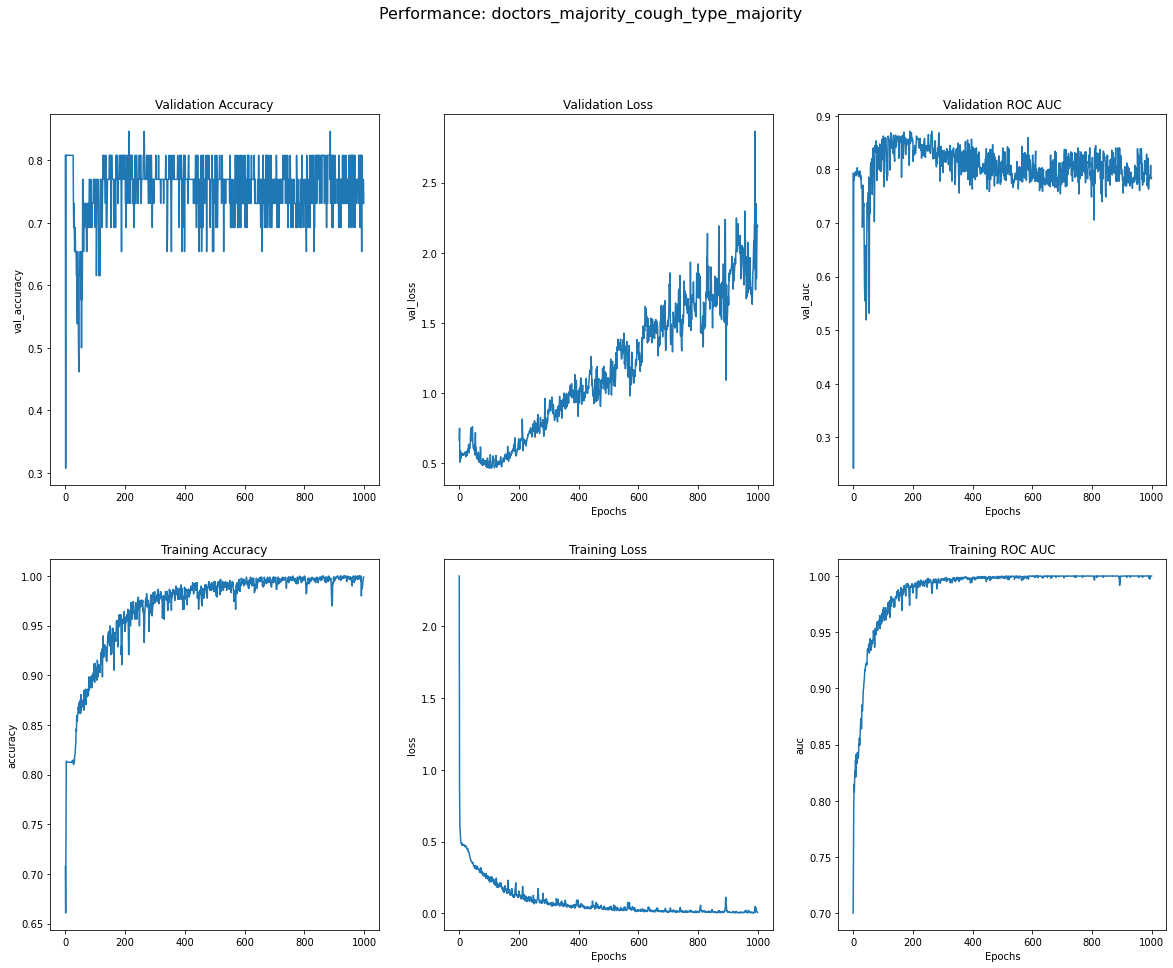

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        21
           1       0.50      0.20      0.29         5

    accuracy                           0.81        26
   macro avg       0.67      0.58      0.59        26
weighted avg       0.77      0.81      0.77        26

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.98      0.89      0.94       730
           1       0.67      0.93      0.78       166

    accuracy                           0.90       896
   macro avg       0.83      0.91      0.86       896
weighted avg       0.93      0.90      0.91       896

Starting subset type: doctor1_cough_type_1
...Loaded data
...Split data: train = 641, validation = 161
...Loaded training data using 9 data augmentation types: train_mfccs shape = (5769, 64, 836, 1), tr

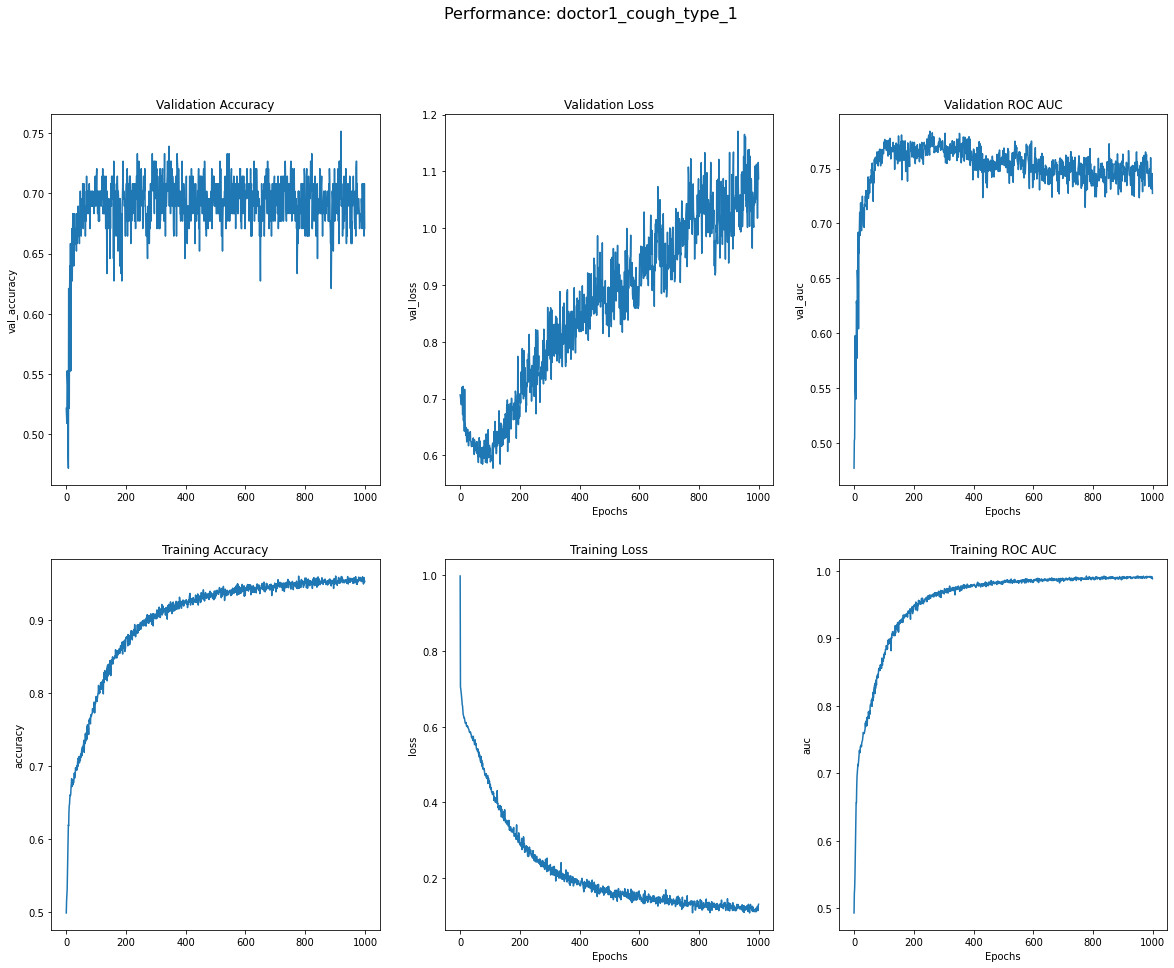

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        85
           1       0.70      0.61      0.65        76

    accuracy                           0.69       161
   macro avg       0.69      0.68      0.69       161
weighted avg       0.69      0.69      0.69       161

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3054
           1       0.96      0.98      0.97      2706

    accuracy                           0.97      5760
   macro avg       0.97      0.97      0.97      5760
weighted avg       0.97      0.97      0.97      5760

Starting subset type: doctor2_cough_type_2
...Loaded data
...Split data: train = 640, validation = 161
...Loaded training data using 9 data augmentation types: train_mfccs shape = (5760, 64, 836, 1), tr

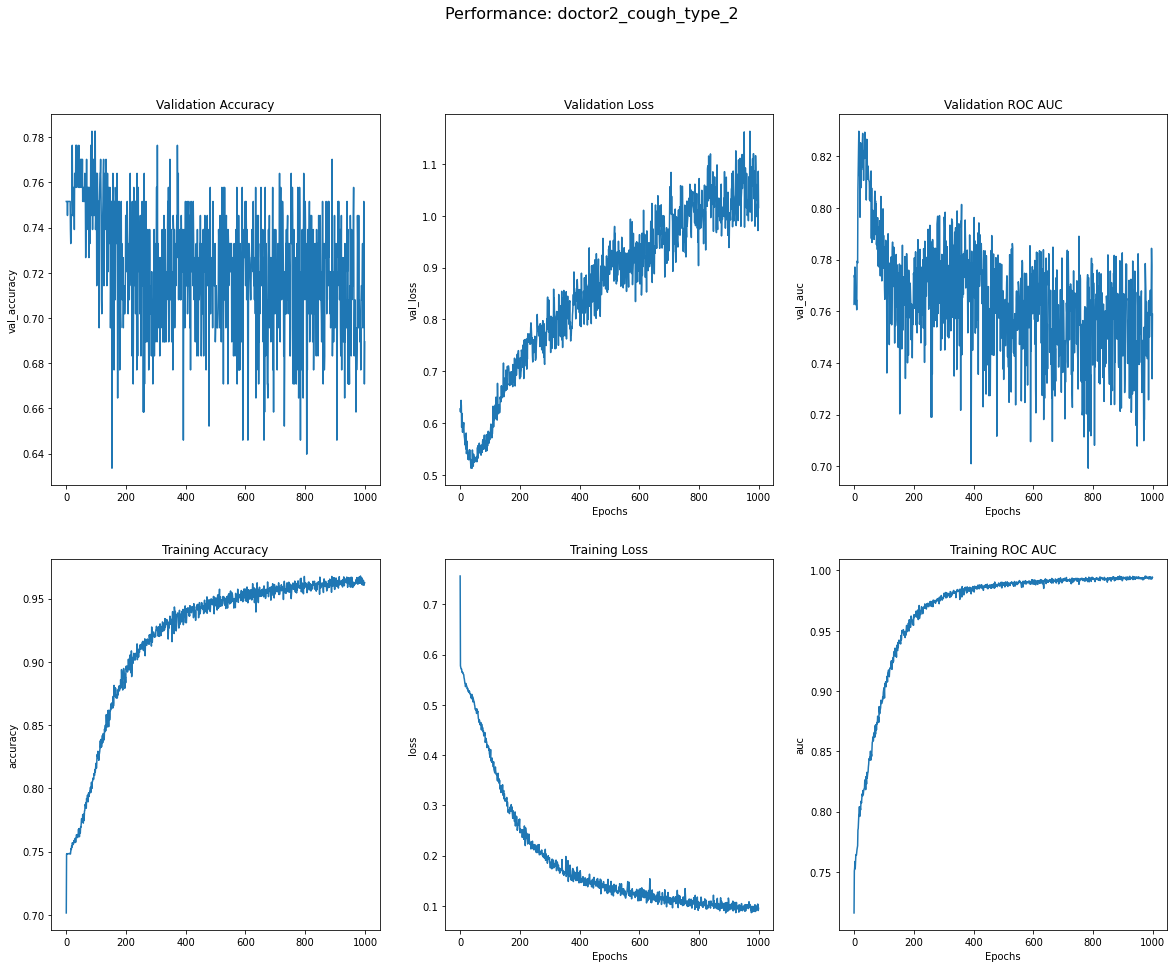

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.76      0.95      0.85       121
           1       0.40      0.10      0.16        40

    accuracy                           0.74       161
   macro avg       0.58      0.53      0.50       161
weighted avg       0.67      0.74      0.68       161

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.77      0.97      0.85      4311
           1       0.55      0.12      0.19      1449

    accuracy                           0.75      5760
   macro avg       0.66      0.54      0.52      5760
weighted avg       0.71      0.75      0.69      5760

Starting subset type: doctor3_cough_type_3
...Loaded data
...Split data: train = 636, validation = 159
...Loaded training data using 9 data augmentation types: train_mfccs shape = (5724, 64, 836, 1), tr

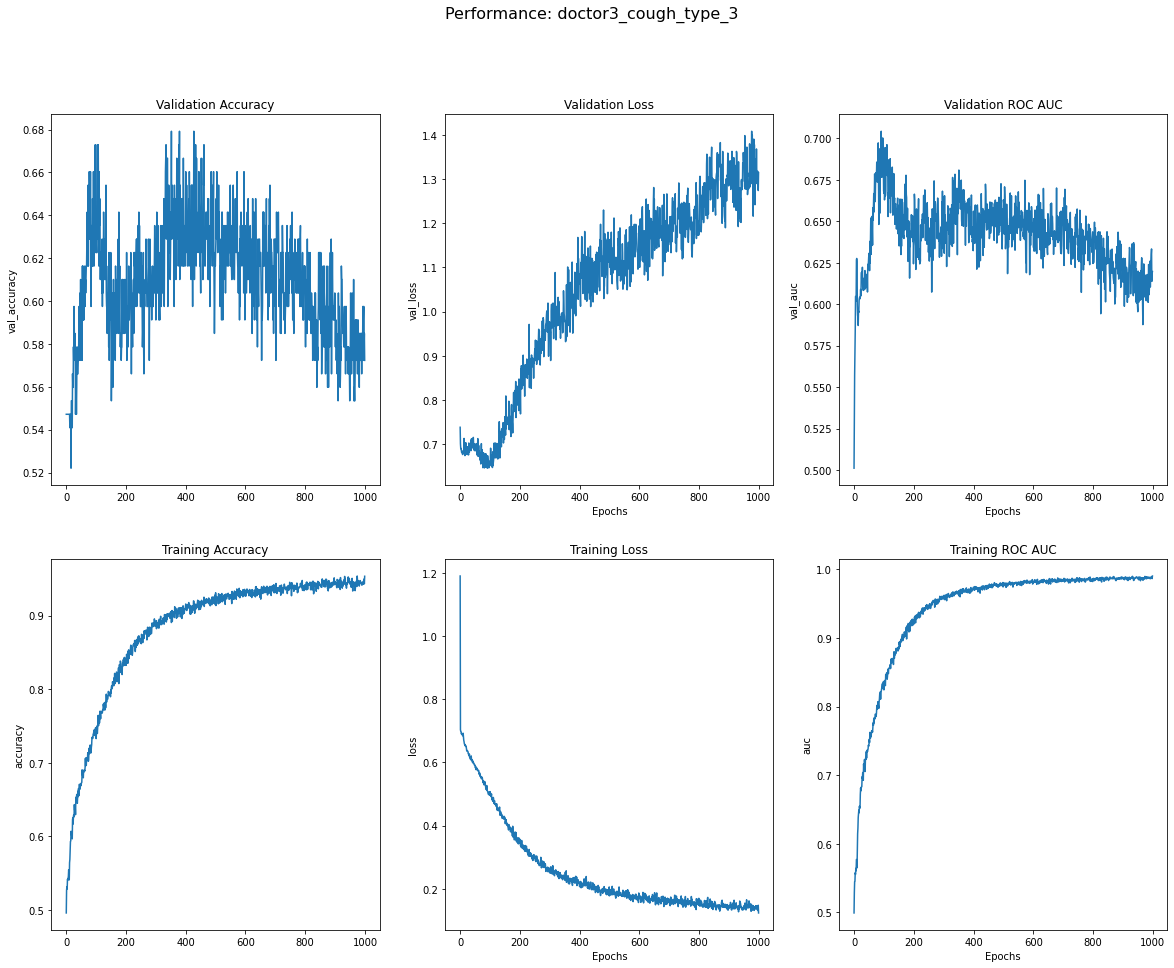

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.68      0.47      0.56        72
           1       0.65      0.82      0.72        87

    accuracy                           0.66       159
   macro avg       0.67      0.64      0.64       159
weighted avg       0.66      0.66      0.65       159

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.82      0.61      0.70      2533
           1       0.74      0.89      0.81      3099

    accuracy                           0.77      5632
   macro avg       0.78      0.75      0.75      5632
weighted avg       0.78      0.77      0.76      5632

Starting subset type: doctor4_cough_type_4
...Loaded data
...Split data: train = 640, validation = 161


In [ ]:
for subset_type in subsets.keys():
  model_save_path = audiofile_converted_path + subset_type + '_cnn_model.h5'
  history_save_path = audiofile_converted_path + subset_type + '_cnn_history.pkl'
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9)

  model_history = pickle.load(open(history_save_path, 'rb'))
  best_model = models.load_model(filepath=model_save_path)

  # evaluate model
  evaluate_dnn_model(model_history, best_model, t_gen=train_gen, v_gen=validation_gen, subset_type=subset_type)

  del train_gen
  del validation_gen
  del model_history
  del best_model
  gc.collect()

Evaluation of:


*   doctor4_cough_type_4

Rest are in the next cell because it took too much memory

Starting subset type: doctor4_cough_type_4
...Loaded data
...Split data: train = 640, validation = 161
...Loaded training data using 9 data augmentation types: train_mfccs shape = (5760, 64, 836, 1), train_lables shape = (5760,)
...Loaded validation data: validation_mfccs shape = (161, 64, 836, 1), validation_labels shape = (161,)
...Loaded train and validation data generator


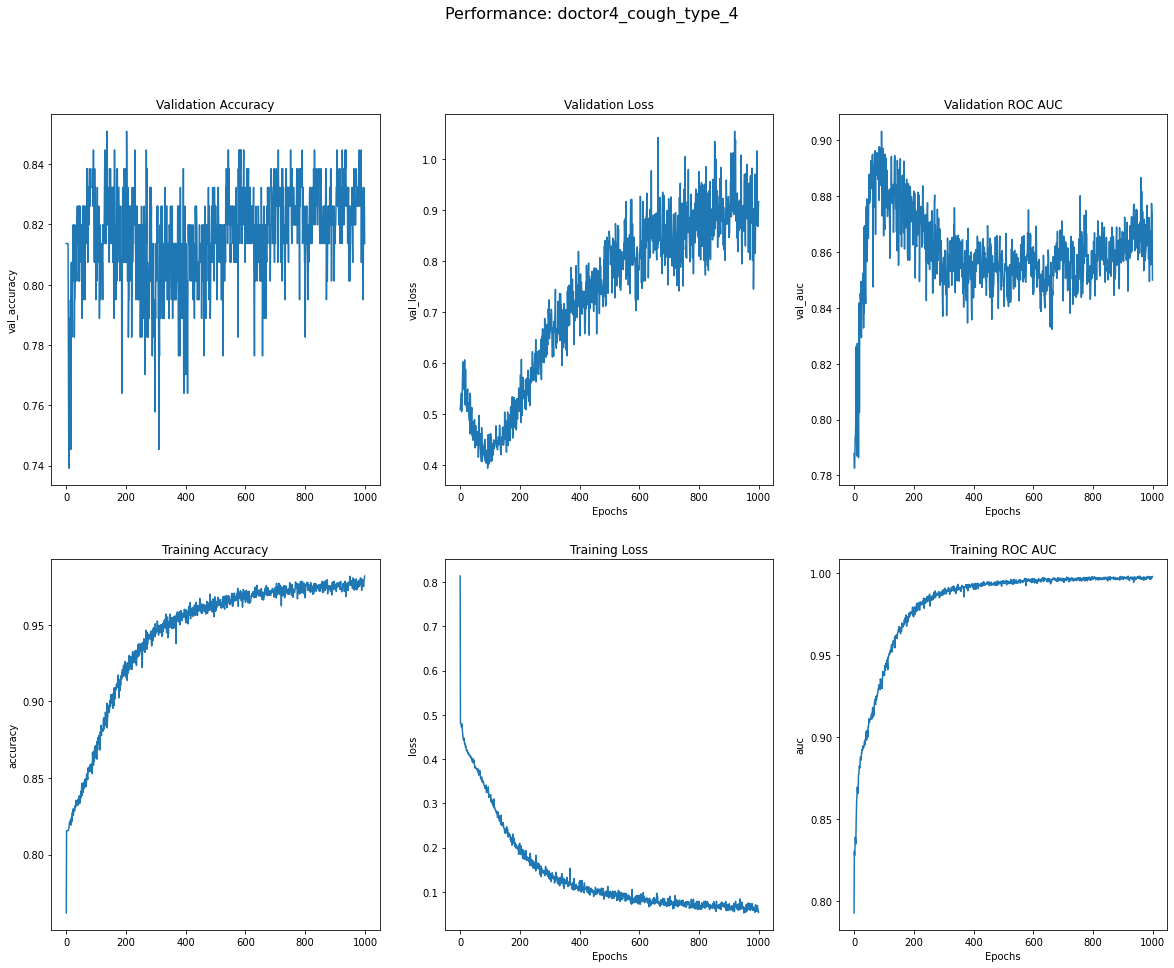

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       131
           1       0.58      0.37      0.45        30

    accuracy                           0.83       161
   macro avg       0.72      0.65      0.68       161
weighted avg       0.81      0.83      0.82       161

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4698
           1       0.81      0.50      0.62      1062

    accuracy                           0.89      5760
   macro avg       0.85      0.74      0.77      5760
weighted avg       0.88      0.89      0.87      5760

Starting subset type: individual_status
...Loaded data
...Split data: train = 1118, validation = 280


In [ ]:
for subset_type in subsets.keys():
  model_save_path = audiofile_converted_path + subset_type + '_cnn_model.h5'
  history_save_path = audiofile_converted_path + subset_type + '_cnn_history.pkl'
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9)

  model_history = pickle.load(open(history_save_path, 'rb'))
  best_model = models.load_model(filepath=model_save_path)

  # evaluate model
  evaluate_dnn_model(model_history, best_model, t_gen=train_gen, v_gen=validation_gen, subset_type=subset_type)

  del train_gen
  del validation_gen
  del model_history
  del best_model
  gc.collect()

Evaluation of:


*   individual_status

Starting subset type: individual_status
...Loaded data
...Split data: train = 1118, validation = 280
...Loaded training data using 9 data augmentation types: train_mfccs shape = (10062, 64, 836, 1), train_lables shape = (10062,)
...Loaded validation data: validation_mfccs shape = (280, 64, 836, 1), validation_labels shape = (280,)
...Loaded train and validation data generator


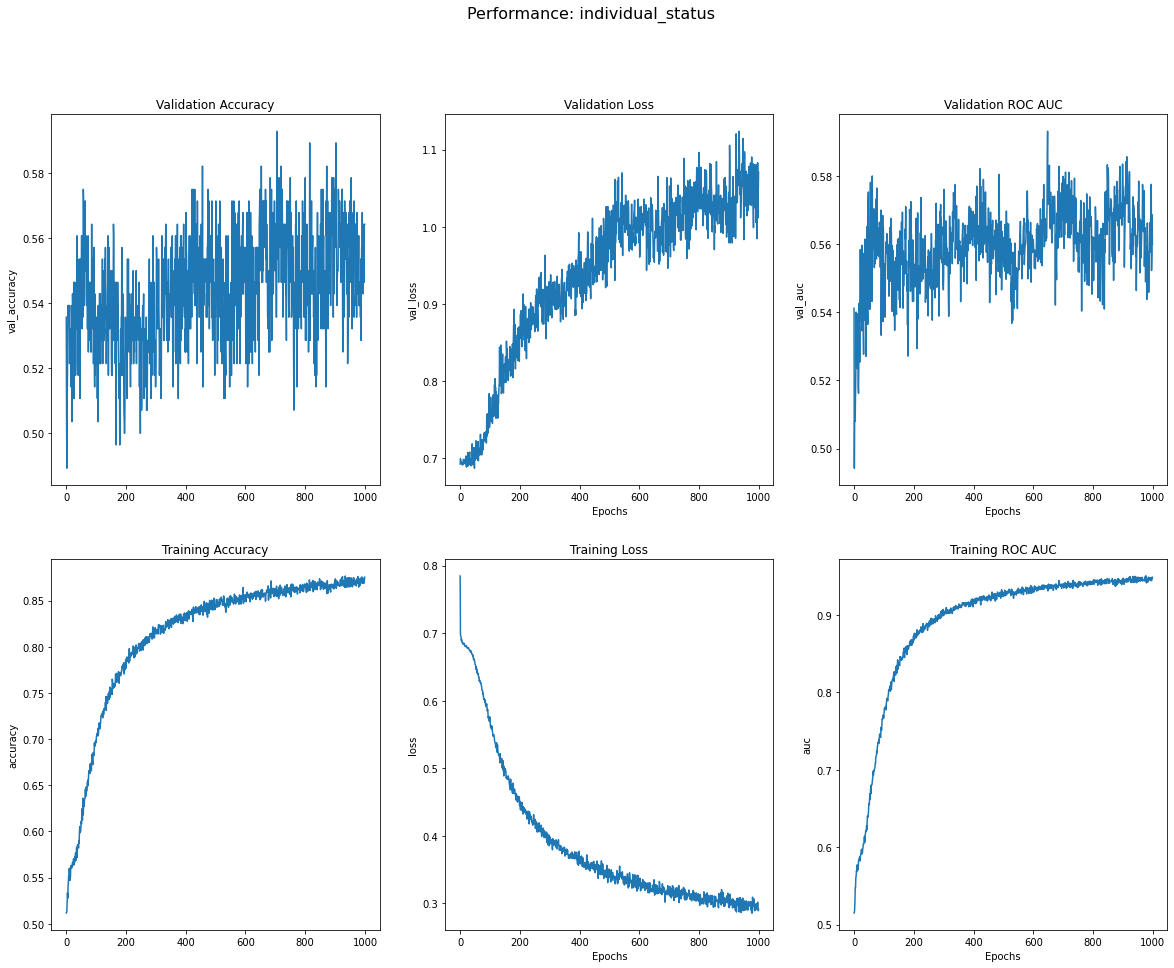

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.61      0.42      0.50       140
           1       0.56      0.73      0.63       140

    accuracy                           0.57       280
   macro avg       0.58      0.57      0.56       280
weighted avg       0.58      0.57      0.56       280

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      4992
           1       0.92      0.99      0.95      4992

    accuracy                           0.95      9984
   macro avg       0.95      0.95      0.95      9984
weighted avg       0.95      0.95      0.95      9984



In [ ]:
for subset_type in subsets.keys():
  model_save_path = audiofile_converted_path + subset_type + '_cnn_model.h5'
  history_save_path = audiofile_converted_path + subset_type + '_cnn_history.pkl'
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen = get_data_generator(subset_type, n_data_augmentation=9)

  model_history = pickle.load(open(history_save_path, 'rb'))
  best_model = models.load_model(filepath=model_save_path)

  # evaluate model
  evaluate_dnn_model(model_history, best_model, t_gen=train_gen, v_gen=validation_gen, subset_type=subset_type)

  del train_gen
  del validation_gen
  del model_history
  del best_model
  gc.collect()

### Random Forest

*   Random Forest is an algorithm that consists of a collection of decision trees
*   The decision trees take a random subset of the data and try to generate rules 
*   Then all the decision trees vote to classify a new data point 
*   The new data point will belong to the majority voted class 

Müller and Guido (2017) suggest using max_features = ‘log2’ for random forest regression problems and max_features = ‘sqrt’ for classification problems.

In [53]:
parameters = {'max_depth': 10, 'max_features': 'sqrt',  'min_samples_leaf': 2,  'min_samples_split': 4, 'n_estimators': 1800}

In [54]:
for subset_type in subsets.keys():
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9)

  print('Starting Fit of Random Forest Classifier')
  model = RandomForestClassifier(**parameters)
  model.fit(train_gen[0], train_gen[1])

  model_save = {
      'train_x': train_gen[0],
      'train_y': train_gen[1],
      'validation_x': validation_gen[0],
      'validation_y': validation_gen[1],
      'n_classes': n_classes,
      'model': model
  }
  print('Completed Fit of Random Forest Classifier')

  model_save_path = audiofile_converted_path + subset_type + '_RandomForest.pkl'
  f_out = open(model_save_path, 'wb')
  pickle.dump(model_save, f_out)
  f_out.close()

  del train_gen
  del validation_gen
  del n_classes
  del model
  gc.collect()

Starting subset type: individual_status
...Loaded data
...Split data: train = 1118, validation = 280
...Loaded training data using 9 data augmentation types: train_mfccs shape = (10062, 53504), train_lables shape = (10062, 2)
...Loaded validation data: validation_mfccs shape = (280, 53504), validation_labels shape = (280, 2)
Starting Fit of Random Forest Classifier
Completed Fit of Random Forest Classifier


#### Evaluate Models

In [53]:
def evaluate_sklearn_model(train_x, train_y, validation_x, validation_y, model, subset_type):
  # normalize training from categorical to label
  train_y_normalized = train_y.argmax(axis=-1)
  validation_y_normalized = validation_y.argmax(axis=-1)
  # generate predictions for training and validation
  train_y_predict = model.predict(train_x)
  validation_y_predict = model.predict(validation_x)

  # display classification results
  print('-'*30 + ' VALIDATION ' + '-'*30)
  print(classification_report(validation_y_normalized, validation_y_predict.argmax(axis=-1), zero_division=1))
  print('-'*30 + ' TRAINING ' + '-'*30)
  print(classification_report(train_y_normalized, train_y_predict.argmax(axis=-1), zero_division=1))

  model_results = {}
  for y in [0, 1]:
    precisions, recalls, thresholds = precision_recall_curve(validation_y[:,y], validation_y_predict[:,y])
    fpr, tpr, thresholdsROC = roc_curve(validation_y[:,y], validation_y_predict[:,y])
    model_results.update({y: {
        'precisions': precisions,
        'recalls': recalls,
        'thresholds': thresholds,
        'fpr': fpr,
        'tpr': tpr,
        'thresholdsROC': thresholdsROC
    }})

  i = 0
  fig, axarr = plt.subplots(nrows = 2, ncols = 3, figsize=(20,15))
  for label, metadata in model_results.items():
    # precision recall vs threshold
    axarr[i, 0].plot(metadata['thresholds'], metadata['precisions'][:-1], "b--", label="Precision", linewidth=2)
    axarr[i, 0].plot(metadata['thresholds'], metadata['recalls'][:-1], "g-", label="Recall", linewidth=2)
    axarr[i, 0].set_xlabel("Threshold", fontsize=16)
    axarr[i, 0].legend(loc="upper right", fontsize=16)
    axarr[i, 0].set_ylim([0, 1])
    axarr[i, 0].set_xlim([-4, 5])
    axarr[i, 0].title.set_text('Precision & Recall vs Threshold - Label: {}'.format(i))

    # precision vs recall
    axarr[i, 1].plot(metadata['recalls'], metadata['precisions'], "b-", linewidth=2)
    axarr[i, 1].set_xlabel("Recall", fontsize=16)
    axarr[i, 1].set_ylabel("Precision", fontsize=16)
    axarr[i, 1].axis([0, 1, 0, 1])
    axarr[i, 1].title.set_text('Precision vs Recall - Label: {}'.format(i))

    # ROC Curve
    axarr[i, 2].plot(metadata['fpr'], metadata['tpr'], linewidth=2, label=label)
    axarr[i, 2].plot([0, 1], [0, 1], 'k--')
    axarr[i, 2].axis([0, 1, 0, 1])
    axarr[i, 2].set_xlabel('False Positive Rate', fontsize=16)
    axarr[i, 2].set_ylabel('True Positive Rate', fontsize=16)
    axarr[i, 2].title.set_text('ROC Curve - Label: {}'.format(i))

    # iterate labels
    i+=1

  plt.show()

  
  del train_y_normalized
  del validation_y_normalized
  del train_y_predict
  del validation_y_predict
  del model_results
  gc.collect()

==================== doctors_majority_cough_type_majority ====================

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.00      0.00         5

    accuracy                           0.81        26
   macro avg       0.90      0.50      0.45        26
weighted avg       0.84      0.81      0.72        26

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       738
           1       1.00      0.56      0.71       171

    accuracy                           0.92       909
   macro avg       0.95      0.78      0.83       909
weighted avg       0.92      0.92      0.91       909



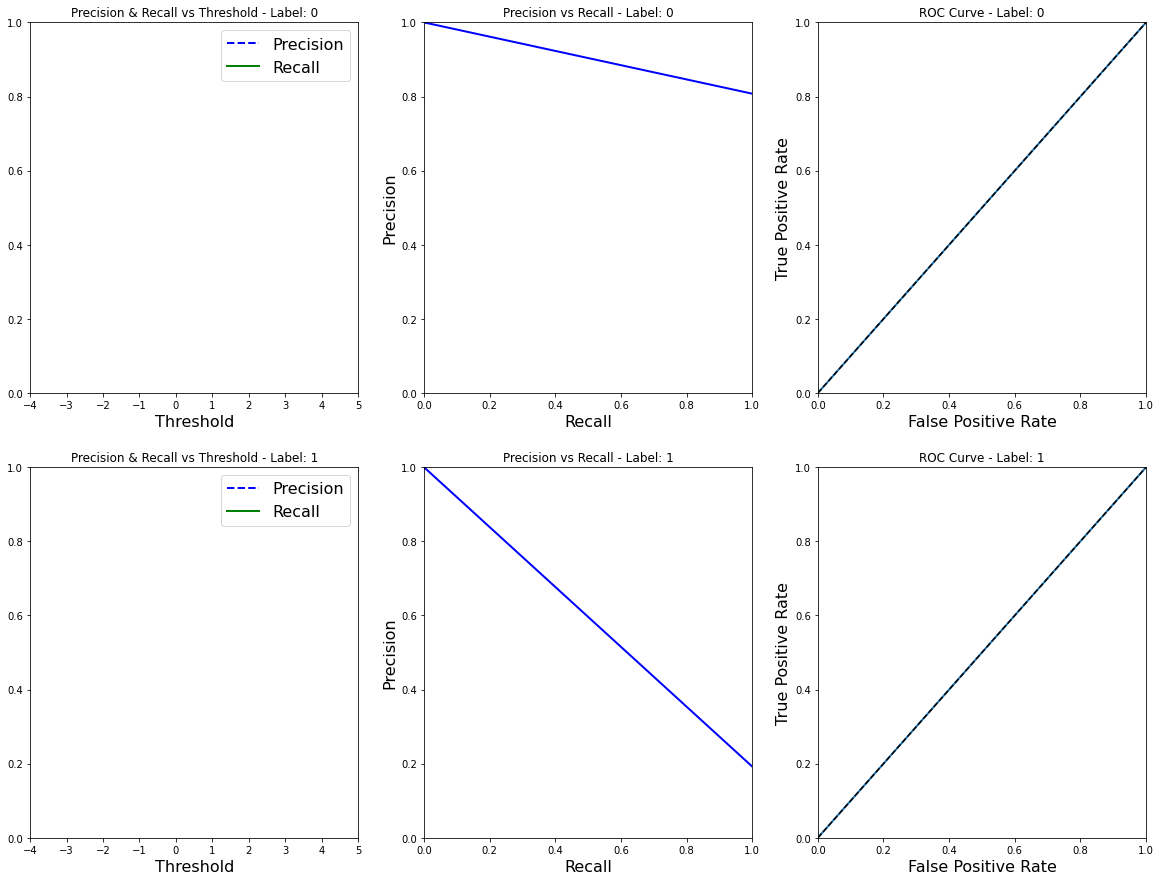

==================== doctor1_cough_type_1 ====================

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.54      0.78      0.63        85
           1       0.50      0.25      0.33        76

    accuracy                           0.53       161
   macro avg       0.52      0.51      0.48       161
weighted avg       0.52      0.53      0.49       161

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3060
           1       1.00      0.89      0.94      2709

    accuracy                           0.95      5769
   macro avg       0.96      0.94      0.95      5769
weighted avg       0.95      0.95      0.95      5769



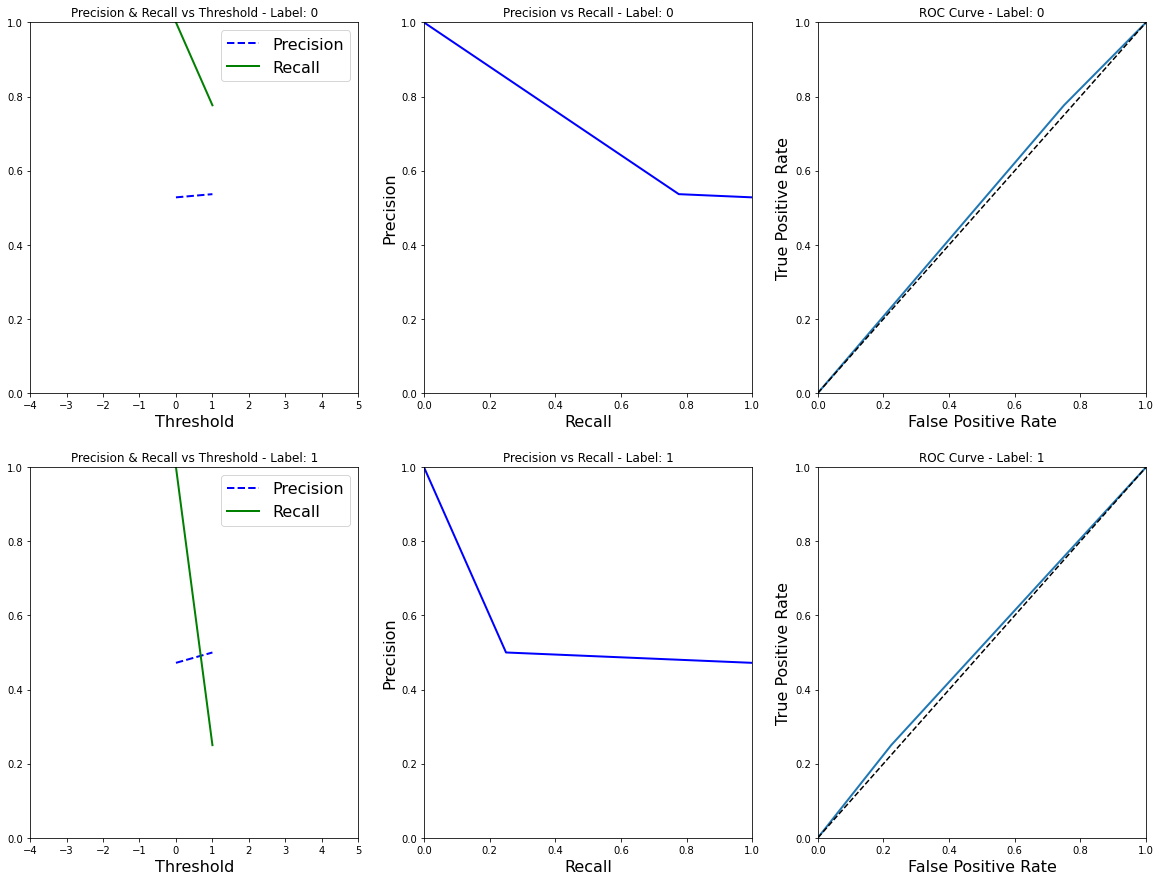

==================== doctor2_cough_type_2 ====================

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       121
           1       1.00      0.00      0.00        40

    accuracy                           0.75       161
   macro avg       0.88      0.50      0.43       161
weighted avg       0.81      0.75      0.64       161

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4311
           1       1.00      0.12      0.21      1449

    accuracy                           0.78      5760
   macro avg       0.89      0.56      0.54      5760
weighted avg       0.83      0.78      0.70      5760



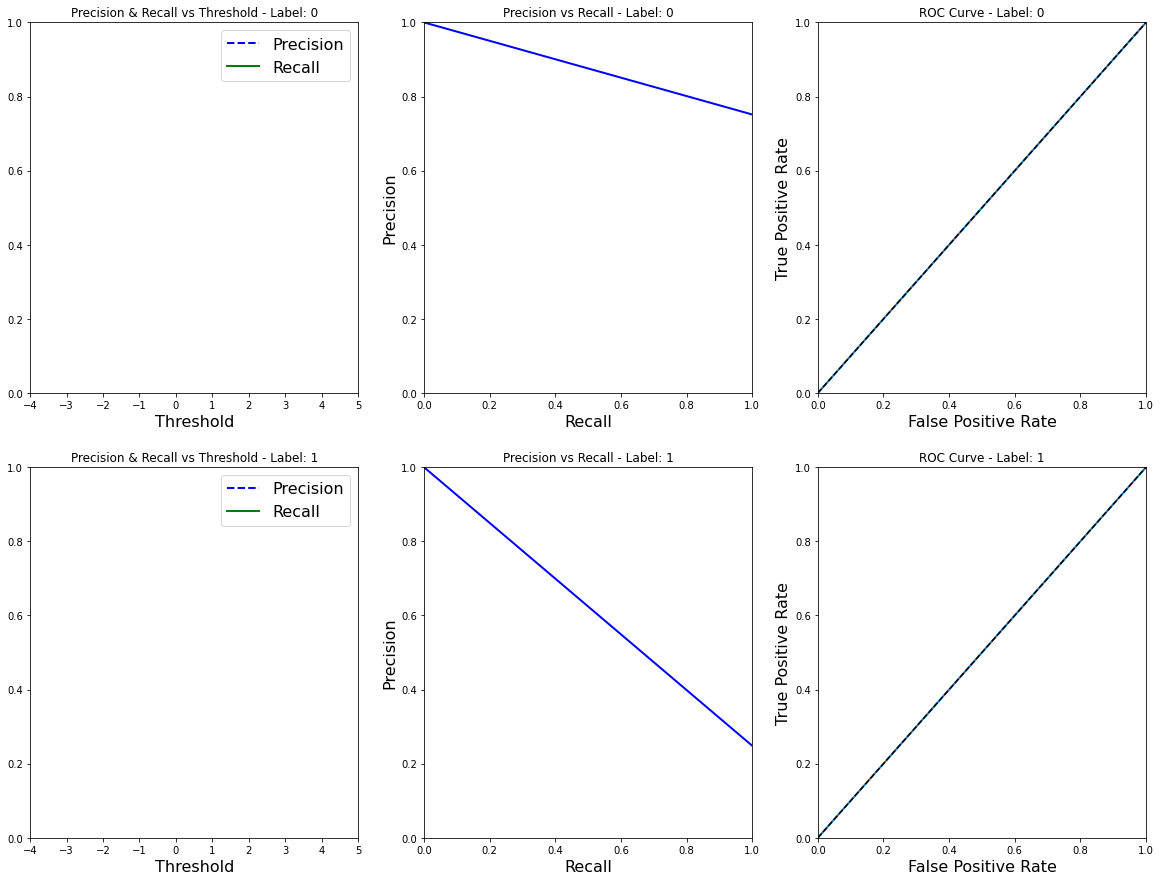

==================== doctor3_cough_type_3 ====================

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.68      0.21      0.32        72
           1       0.58      0.92      0.71        87

    accuracy                           0.60       159
   macro avg       0.63      0.56      0.52       159
weighted avg       0.63      0.60      0.54       159

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2574
           1       0.93      1.00      0.97      3150

    accuracy                           0.96      5724
   macro avg       0.97      0.96      0.96      5724
weighted avg       0.96      0.96      0.96      5724



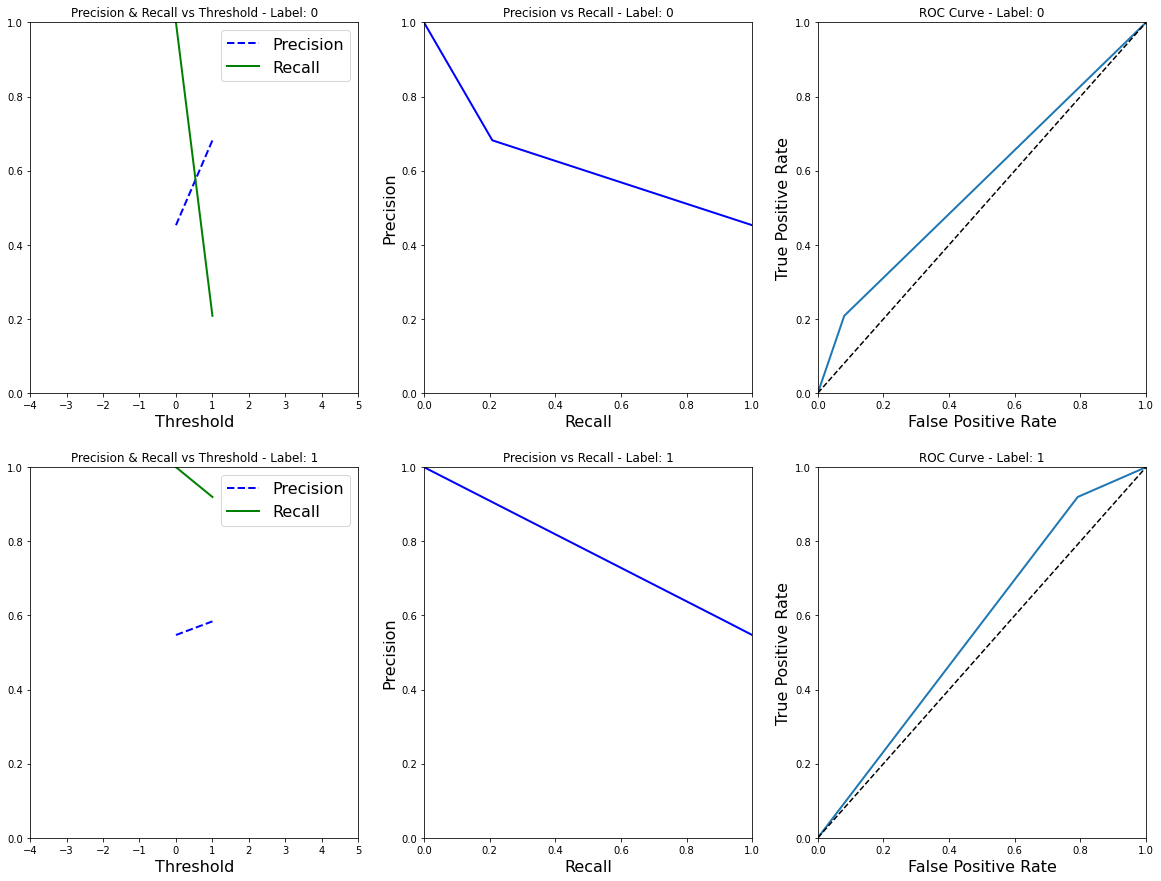

==================== doctor4_cough_type_4 ====================

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       131
           1       1.00      0.00      0.00        30

    accuracy                           0.81       161
   macro avg       0.91      0.50      0.45       161
weighted avg       0.85      0.81      0.73       161

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      4698
           1       1.00      0.07      0.13      1062

    accuracy                           0.83      5760
   macro avg       0.91      0.53      0.52      5760
weighted avg       0.86      0.83      0.76      5760



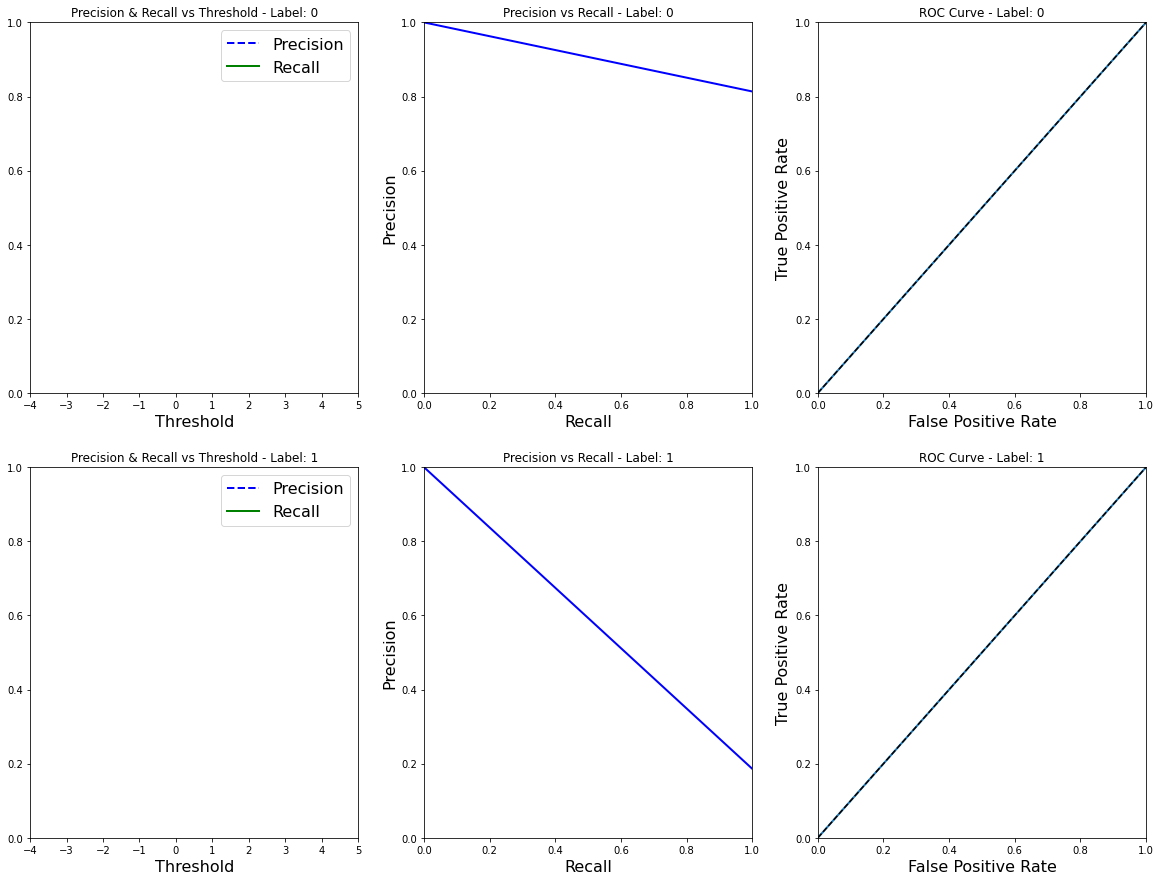

In [88]:
for subset_type in subsets.keys():
  model_save_path = audiofile_converted_path + subset_type + '_RandomForest.pkl'
  print('='*20 + ' ' + subset_type + ' ' + '='*20)
  print('')
  model_metadata = pickle.load(open(model_save_path, 'rb'))

  # evaluate model
  evaluate_sklearn_model(model_metadata['train_x'], model_metadata['train_y'], model_metadata['validation_x'], 
                         model_metadata['validation_y'], model_metadata['model'], subset_type)

  del model_metadata
  gc.collect()

### Gradient Boosting

In [54]:
subsets = {
    'doctors_majority_cough_type_majority':  {'target_class': 'cough_type_majority', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctors_majority_cough_type_majority.pkl'},
    'doctor1_cough_type_1': {'target_class': 'cough_type_1', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor1_cough_type_1.pkl'},
    'doctor2_cough_type_2': {'target_class': 'cough_type_2', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor2_cough_type_2.pkl'},
#    'doctor3_cough_type_3': {'target_class': 'cough_type_3', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor3cough_type_3.pkl'},
#    'doctor4_cough_type_4': {'target_class': 'cough_type_4', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor4cough_type_4.pkl'},
#    'individual_status': {'target_class': 'status', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/individual_status.pkl'}
}

In [55]:
parameters = {'n_estimators': 3000, 'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt',\
                 'min_samples_leaf': 15, 'min_samples_split': 10}

In [ ]:
for subset_type in subsets.keys():
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9)

  print('Starting Fit of Gradient Boosting Classifier')
  model = GradientBoostingClassifier(**parameters)
  model.fit(train_gen[0], train_gen[1].argmax(axis=-1))

  model_save = {
      'train_x': train_gen[0],
      'train_y': train_gen[1].argmax(axis=-1),
      'validation_x': validation_gen[0],
      'validation_y': validation_gen[1].argmax(axis=-1),
      'n_classes': n_classes,
      'model': model
  }
  print('Completed Fit of Gradient Boosting Classifier')

  model_save_path = audiofile_converted_path + subset_type + '_GradientBoosting.pkl'
  f_out = open(model_save_path, 'wb')
  pickle.dump(model_save, f_out)
  f_out.close()

  del train_gen
  del validation_gen
  del n_classes
  del model
  gc.collect()

Starting subset type: doctors_majority_cough_type_majority
...Loaded data
...Split data: train = 101, validation = 26
...Loaded training data using 9 data augmentation types: train_mfccs shape = (909, 53504), train_lables shape = (909, 2)
...Loaded validation data: validation_mfccs shape = (26, 53504), validation_labels shape = (26, 2)
Starting Fit of Gradient Boosting Classifier
Completed Fit of Gradient Boosting Classifier
Starting subset type: doctor1_cough_type_1
...Loaded data
...Split data: train = 641, validation = 161
...Loaded training data using 9 data augmentation types: train_mfccs shape = (5769, 53504), train_lables shape = (5769, 2)
...Loaded validation data: validation_mfccs shape = (161, 53504), validation_labels shape = (161, 2)
Starting Fit of Gradient Boosting Classifier
Completed Fit of Gradient Boosting Classifier
Starting subset type: doctor2_cough_type_2
...Loaded data
...Split data: train = 640, validation = 161


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


...Loaded training data using 9 data augmentation types: train_mfccs shape = (5760, 53504), train_lables shape = (5760, 2)
...Loaded validation data: validation_mfccs shape = (161, 53504), validation_labels shape = (161, 2)
Starting Fit of Gradient Boosting Classifier
Completed Fit of Gradient Boosting Classifier
Starting subset type: doctor3_cough_type_3


#### Evaluate Models

In [58]:
def evaluate_sklearn_model(train_x, train_y, validation_x, validation_y, model, subset_type):
  # normalize training from categorical to label
  #train_y_normalized = train_y.argmax(axis=-1)
  #validation_y_normalized = validation_y.argmax(axis=-1)
  # generate predictions for training and validation
  #train_y_predict = model.predict(train_x)
  print('...predicting validation')
  validation_y_predict = model.predict(validation_x)
  print('...completed predicting validation')

  # display classification results
  print('-'*30 + ' VALIDATION ' + '-'*30)
  print(classification_report(validation_y, validation_y_predict, zero_division=1))
  #print('-'*30 + ' TRAINING ' + '-'*30)
  #print(classification_report(train_y, train_y_predict, zero_division=1))

  
  #del train_y_normalized
  #del validation_y_normalized
  #del train_y_predict
  del validation_y_predict
  gc.collect()

In [66]:
for subset_type in subsets.keys():
  model_save_path = audiofile_converted_path + subset_type + '_GradientBoosting.pkl'
  print('='*20 + ' ' + subset_type + ' ' + '='*20)
  print('')
  model_metadata = pickle.load(open(model_save_path, 'rb'))

  # evaluate model
  evaluate_sklearn_model(model_metadata['train_x'], model_metadata['train_y'], model_metadata['validation_x'], 
                         model_metadata['validation_y'], model_metadata['model'], subset_type)

  del model_metadata
  gc.collect()

==================== doctors_majority_cough_type_majority ====================

------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.00      0.00         5

    accuracy                           0.81        26
   macro avg       0.90      0.50      0.45        26
weighted avg       0.84      0.81      0.72        26

------------------------------ TRAINING ------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       738
           1       1.00      1.00      1.00       171

    accuracy                           1.00       909
   macro avg       1.00      1.00      1.00       909
weighted avg       1.00      1.00      1.00       909

==================== doctor1_cough_type_1 ====================

------------------------------ VALIDATION ----------------

### SVM

In [60]:
subsets = {
#    'doctors_majority_cough_type_majority':  {'target_class': 'cough_type_majority', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctors_majority_cough_type_majority.pkl'},
    'doctor1_cough_type_1': {'target_class': 'cough_type_1', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor1_cough_type_1.pkl'},
#    'doctor2_cough_type_2': {'target_class': 'cough_type_2', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor2_cough_type_2.pkl'},
#    'doctor3_cough_type_3': {'target_class': 'cough_type_3', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor3cough_type_3.pkl'},
#    'doctor4_cough_type_4': {'target_class': 'cough_type_4', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor4cough_type_4.pkl'},
#    'individual_status': {'target_class': 'status', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/individual_status.pkl'}
}

In [70]:
parameters = {'C': 20, 'gamma': 0.0003}

In [71]:
for subset_type in subsets.keys():
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9)

  print('Starting Fit of SVM Classifier')
  model = SVC(**parameters)
  model.fit(train_gen[0], train_gen[1].argmax(axis=-1))

  model_save = {
      'train_x': train_gen[0],
      'train_y': train_gen[1].argmax(axis=-1),
      'validation_x': validation_gen[0],
      'validation_y': validation_gen[1].argmax(axis=-1),
      'n_classes': n_classes,
      'model': model
  }
  print('Completed Fit of SVM Classifier')

  model_save_path = audiofile_converted_path + subset_type + '_SVM.pkl'
  f_out = open(model_save_path, 'wb')
  pickle.dump(model_save, f_out)
  f_out.close()

  del train_gen
  del validation_gen
  del n_classes
  del model
  gc.collect()

Starting subset type: doctor1_cough_type_1
...Loaded data
...Split data: train = 641, validation = 161
...Loaded training data using 9 data augmentation types: train_mfccs shape = (5769, 53504), train_lables shape = (5769, 2)
...Loaded validation data: validation_mfccs shape = (161, 53504), validation_labels shape = (161, 2)
Starting Fit of SVM Classifier
Completed Fit of SVM Classifier


#### Evaluate Models

In [61]:
for subset_type in subsets.keys():
  model_save_path = audiofile_converted_path + subset_type + '_SVM.pkl'
  print('='*20 + ' ' + subset_type + ' ' + '='*20)
  print('')
  model_metadata = pickle.load(open(model_save_path, 'rb'))

  # evaluate model
  evaluate_sklearn_model(model_metadata['train_x'], model_metadata['train_y'], model_metadata['validation_x'], 
                         model_metadata['validation_y'], model_metadata['model'], subset_type)

  del model_metadata
  gc.collect()

==================== doctor1_cough_type_1 ====================

...predicting validation
...completed predicting validation
------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        85
           1       1.00      0.00      0.00        76

    accuracy                           0.53       161
   macro avg       0.76      0.50      0.35       161
weighted avg       0.75      0.53      0.36       161



### Logistic Regression

In [55]:
subsets = {
#    'doctors_majority_cough_type_majority':  {'target_class': 'cough_type_majority', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctors_majority_cough_type_majority.pkl'},
    'doctor1_cough_type_1': {'target_class': 'cough_type_1', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor1_cough_type_1.pkl'},
#    'doctor2_cough_type_2': {'target_class': 'cough_type_2', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor2_cough_type_2.pkl'},
#    'doctor3_cough_type_3': {'target_class': 'cough_type_3', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor3cough_type_3.pkl'},
#    'doctor4_cough_type_4': {'target_class': 'cough_type_4', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/doctor4cough_type_4.pkl'},
#    'individual_status': {'target_class': 'status', 'file_path': '/content/gdrive/My Drive/MSDS-498/converted_files/individual_status.pkl'}
}

In [56]:
parameters = {'max_iter': 1e7}

In [57]:
for subset_type in subsets.keys():
  if subset_type in ['doctors_majority_cough_type_majority', 'doctor1_cough_type_1', 'doctor2_cough_type_2', 'doctor3_cough_type_3', 'doctor4_cough_type_4']:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9, two_class_only=True)
  else:
    train_gen, validation_gen, n_classes = get_data_generator_2d(subset_type, n_data_augmentation=9)

  print('Starting Fit of Logistic Regression Classifier')
  model = LogisticRegression(**parameters)
  model.fit(train_gen[0], train_gen[1].argmax(axis=-1))

  model_save = {
      'train_x': train_gen[0],
      'train_y': train_gen[1].argmax(axis=-1),
      'validation_x': validation_gen[0],
      'validation_y': validation_gen[1].argmax(axis=-1),
      'n_classes': n_classes,
      'model': model
  }
  print('Completed Fit of Logistic Regression Classifier')

  model_save_path = audiofile_converted_path + subset_type + '_LogisticRegression.pkl'
  f_out = open(model_save_path, 'wb')
  pickle.dump(model_save, f_out)
  f_out.close()

  del train_gen
  del validation_gen
  del n_classes
  del model
  gc.collect()

Starting subset type: doctor1_cough_type_1
...Loaded data
...Split data: train = 641, validation = 161
...Loaded training data using 9 data augmentation types: train_mfccs shape = (5769, 53504), train_lables shape = (5769, 2)
...Loaded validation data: validation_mfccs shape = (161, 53504), validation_labels shape = (161, 2)
Starting Fit of Logistic Regression Classifier
Completed Fit of Logistic Regression Classifier


#### Evaluate Models

In [59]:
for subset_type in subsets.keys():
  model_save_path = audiofile_converted_path + subset_type + '_LogisticRegression.pkl'
  print('='*20 + ' ' + subset_type + ' ' + '='*20)
  print('')
  model_metadata = pickle.load(open(model_save_path, 'rb'))

  # evaluate model
  evaluate_sklearn_model(model_metadata['train_x'], model_metadata['train_y'], model_metadata['validation_x'], 
                         model_metadata['validation_y'], model_metadata['model'], subset_type)

  del model_metadata
  gc.collect()

==================== doctor1_cough_type_1 ====================

...predicting validation
...completed predicting validation
------------------------------ VALIDATION ------------------------------
              precision    recall  f1-score   support

           0       0.60      0.61      0.61        85
           1       0.56      0.55      0.56        76

    accuracy                           0.58       161
   macro avg       0.58      0.58      0.58       161
weighted avg       0.58      0.58      0.58       161

